<a href="https://colab.research.google.com/github/seeedata/BADA/blob/main/%ED%83%9D%EC%8B%9C%EB%B9%84%20%EC%9D%B8%EC%83%81%20%EC%9D%B4%ED%9B%84%20%EA%B7%80%EA%B0%80%20%ED%8C%A8%ED%84%B4%20%EB%B3%80%ED%99%94%20%EB%B6%84%EC%84%9D/%EC%A7%80%ED%95%98%EC%B2%A0%20%EC%8B%9C%EA%B3%84%EC%97%B4%20%EA%B7%80%EA%B0%80%EC%8B%9C%EA%B0%84.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#import

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 19 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 1s (9,223 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 120874 files and dire

In [ ]:
from matplotlib import pyplot as plt
plt.rcParams['font.family'] = 'NanumBarunGothic'
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
from datetime import datetime

!pip install pyspark
!pip install tslearn

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm

import itertools
import pandas as pd
import numpy as np
from datetime import datetime

#데이터 전처리

In [ ]:
sub = pd.read_csv('/content/drive/MyDrive/BADA/바다톤/data/8.7_지하철_귀가시간대_데이터통합.csv'); sub

,date,area,count
0,2022-12-01,강남구,89537
1,2022-12-02,강남구,105567
2,2022-12-03,강남구,63954
3,2022-12-04,강남구,41568
4,2022-12-05,강남구,81236
...,...,...,...
600,2023-03-27,송파구,123592
601,2023-03-28,송파구,128811
602,2023-03-29,송파구,132763
603,2023-03-30,송파구,134163


In [ ]:
sub['date'] = sub['date'].astype(str)
sub['date'] = pd.to_datetime(sub['date'])
sub = pd.DataFrame(sub.groupby(['area','date']).sum()['count'])
sub = sub.reset_index(level=0); sub

,area,count
date,,
2022-12-01,강남구,89537
2022-12-02,강남구,105567
2022-12-03,강남구,63954
2022-12-04,강남구,41568
2022-12-05,강남구,81236
...,...,...
2023-03-27,송파구,123592
2023-03-28,송파구,128811
2023-03-29,송파구,132763


In [ ]:
sub_강남 = sub[sub['area']=='강남구']
sub_강서 = sub[sub['area']=='강서구']
sub_관악 = sub[sub['area']=='관악구']
sub_노원 = sub[sub['area']=='노원구']
sub_송파 = sub[sub['area']=='송파구']

#시계열 분석 (귀가시간대, 전체기간)

##데이터의 분포 살펴보기

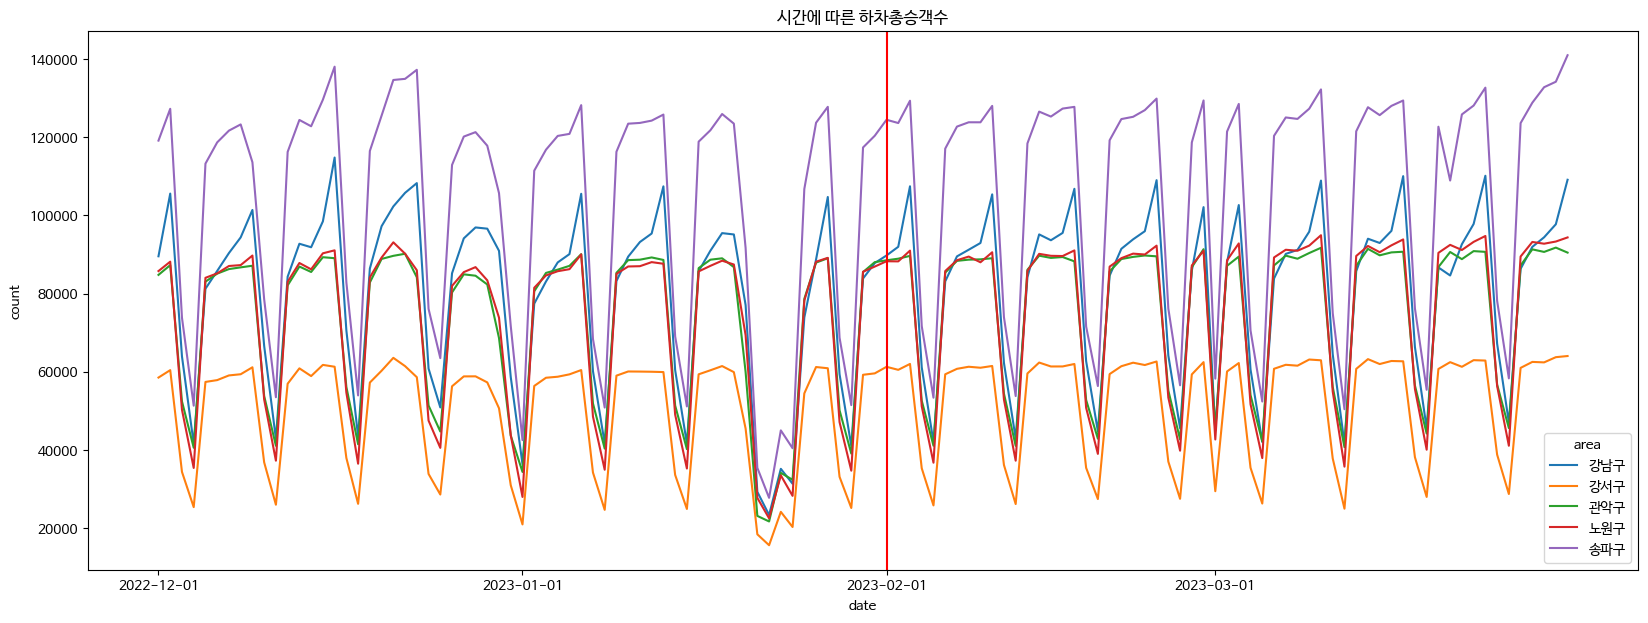

In [ ]:
plt.figure(figsize=(20,7))
ax = sns.lineplot(x=sub.index, y=sub['count'], hue=sub['area'])
plt.title('시간에 따른 하차총승객수')
ax.set_xticks([datetime(2022,12,1),datetime(2023,1,1),datetime(2023,2,1),datetime(2023,3,1)], ['2022-12-01', '2023-01-01', '2023-02-01', '2023-03-01'])
plt.axvline(x=datetime(2023,2,1), ymin=0, ymax=800000, color='red', linestyle='solid')
plt.show()

##stationarity 검정

In [ ]:
def adfuller_test(df):
        result = adfuller(df)

        labels = ['ADF Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used']

        for label, value in zip(labels, result):
            print(label + ' : ' + str(value) )

        if result[1] <= 0.05:
            print('정상성', '\n')
        else:
            print('비정상성', '\n')

In [ ]:
adfuller_test(sub_강남['count'])
adfuller_test(sub_강서['count'])
adfuller_test(sub_관악['count'])
adfuller_test(sub_노원['count'])
adfuller_test(sub_송파['count'])

ADF Test Statistic : -1.7389850187602838
p-value : 0.4111463541516602
#Lags Used : 13
Number of Observations Used : 107
비정상성 

ADF Test Statistic : -1.6532646588187068
p-value : 0.4553383692377375
#Lags Used : 13
Number of Observations Used : 107
비정상성 

ADF Test Statistic : -3.8221113580492174
p-value : 0.0026890181314293818
#Lags Used : 9
Number of Observations Used : 111
정상성 

ADF Test Statistic : -1.5170547001187205
p-value : 0.5250583871000553
#Lags Used : 13
Number of Observations Used : 107
비정상성 

ADF Test Statistic : -1.6998504367513267
p-value : 0.43118953800155146
#Lags Used : 13
Number of Observations Used : 107
비정상성 



강남, 강서, 노원, 송파 비정상성!

##seasonal_decompose

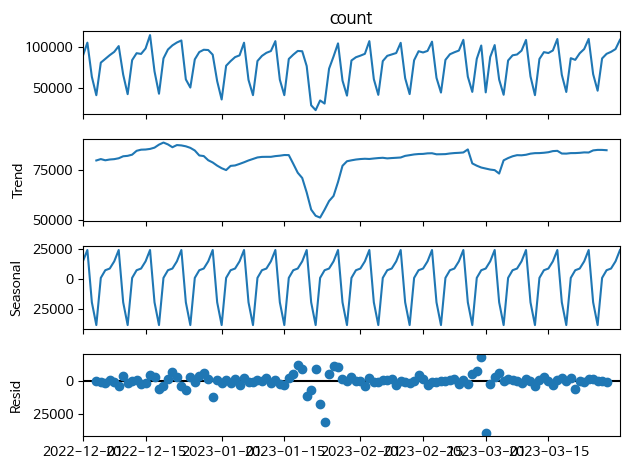

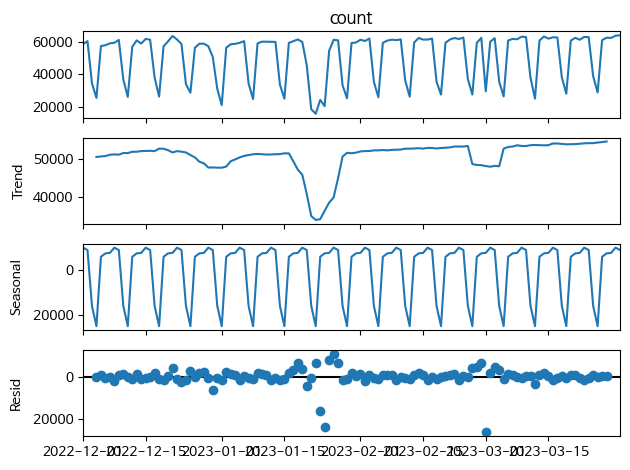

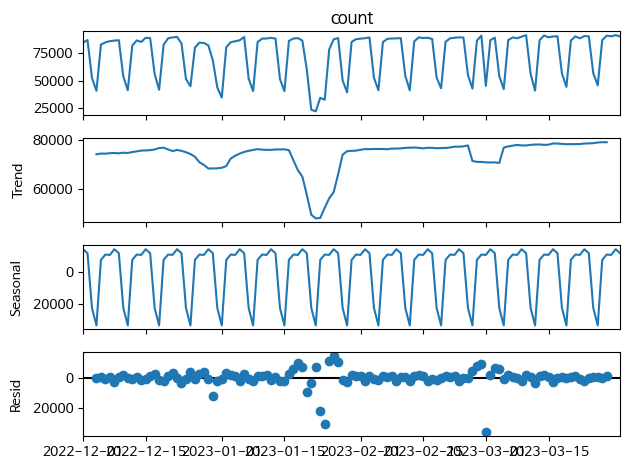

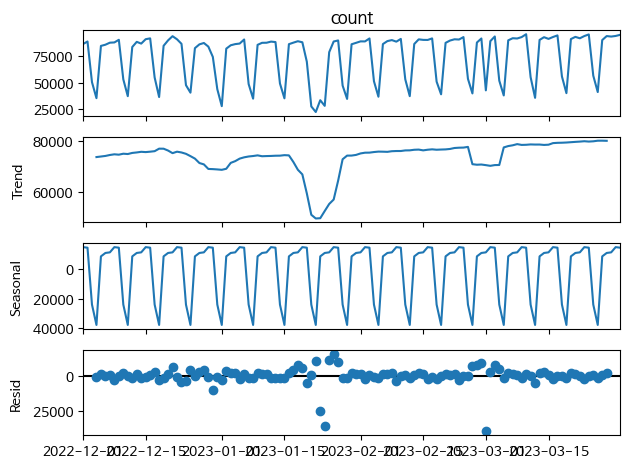

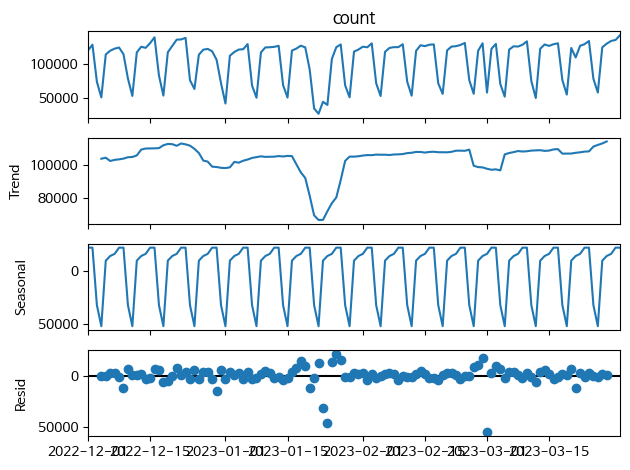

In [ ]:
for df in [sub_강남, sub_강서, sub_관악, sub_노원, sub_송파]:
    series = df['count']
    result = seasonal_decompose(series, model='additive')
    result.plot()

##차분

In [ ]:
def difference(df):
    sub_diff = df['count'].diff()
    sub_diff = sub_diff.dropna()
    return adfuller_test(sub_diff)

In [ ]:
difference(sub_강남)

ADF Test Statistic : -3.833514135146344
p-value : 0.002582444399091987
#Lags Used : 13
Number of Observations Used : 106
정상성 



In [ ]:
difference(sub_강서)

ADF Test Statistic : -3.9122994065320627
p-value : 0.001946171890754821
#Lags Used : 13
Number of Observations Used : 106
정상성 



In [ ]:
difference(sub_노원)

ADF Test Statistic : -3.9245682037479566
p-value : 0.0018612970804836187
#Lags Used : 13
Number of Observations Used : 106
정상성 



In [ ]:
difference(sub_송파)

ADF Test Statistic : -3.8862831343043456
p-value : 0.0021381471513557166
#Lags Used : 13
Number of Observations Used : 106
정상성 



강남, 강서, 노원, 송파에 대해 차분 1회 진행

##acf, pacf

In [ ]:
def acf_pacf(df):

    if df.equals(sub_강남) or df.equals(sub_강서) or df.equals(sub_노원) or df.equals(sub_송파):
        df_diff = df['count'].diff()
        df_diff = df_diff.dropna()

        ax1 = sm.graphics.tsa.plot_acf(df_diff)
        plt.xlabel(df['area'][0])
        plt.show()

        ax2 = sm.graphics.tsa.plot_pacf(df_diff)
        plt.xlabel(df['area'][0])
        plt.show()

    else:
        ax1 = sm.graphics.tsa.plot_acf(df['count'])
        plt.xlabel(df['area'][0])
        plt.show()

        ax2 = sm.graphics.tsa.plot_pacf(df['count'])
        plt.xlabel(df['area'][0])
        plt.show()

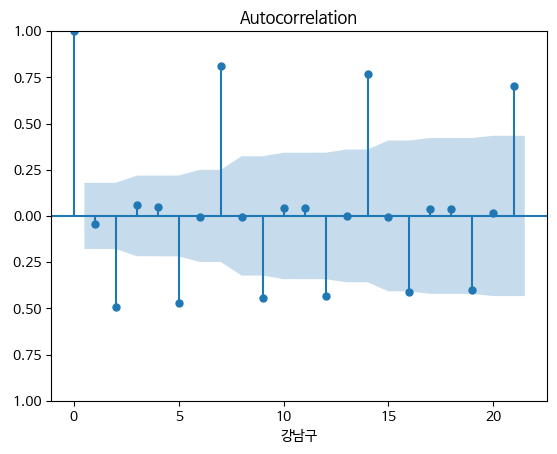

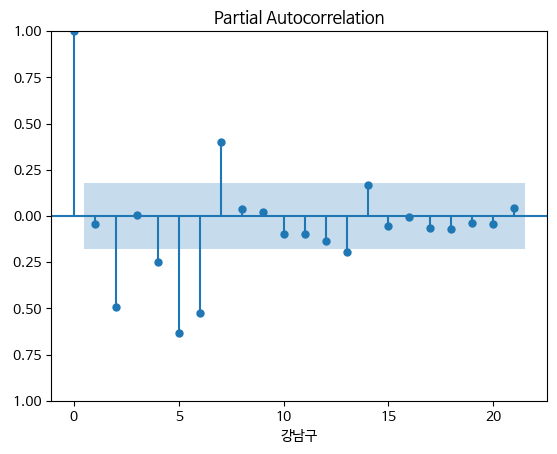

In [ ]:
acf_pacf(sub_강남)

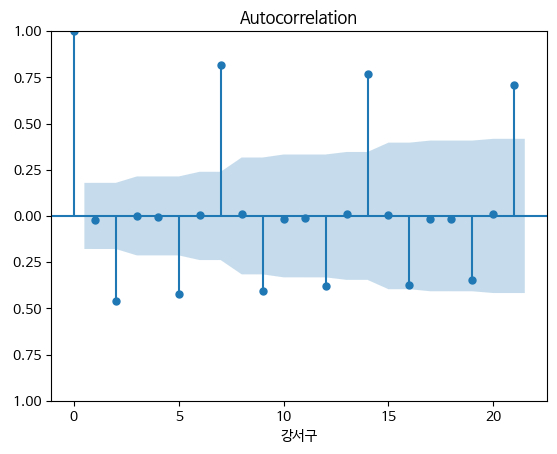

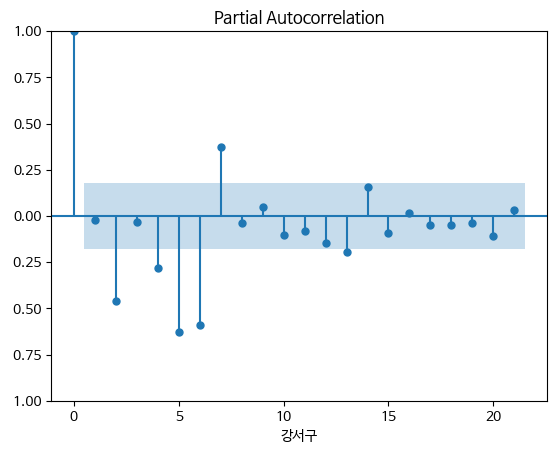

In [ ]:
acf_pacf(sub_강서)

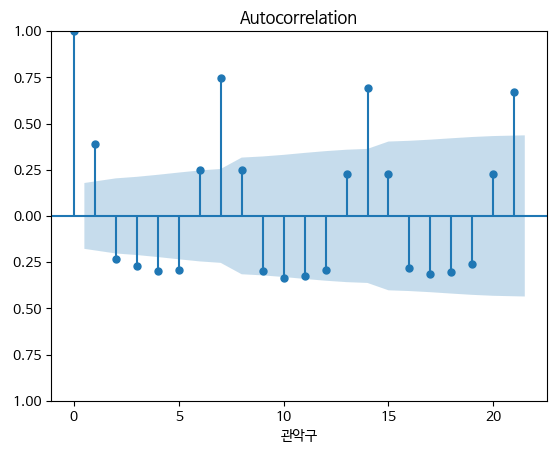

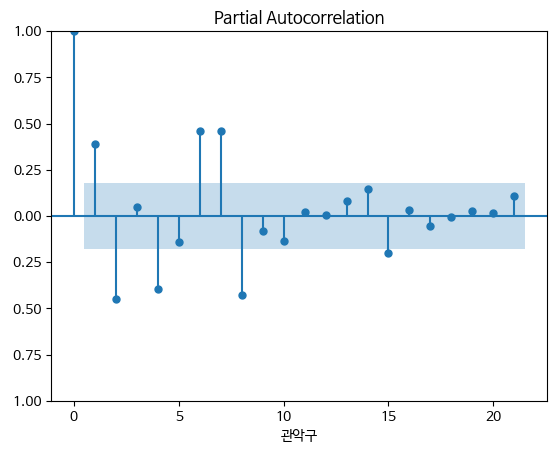

In [ ]:
acf_pacf(sub_관악)

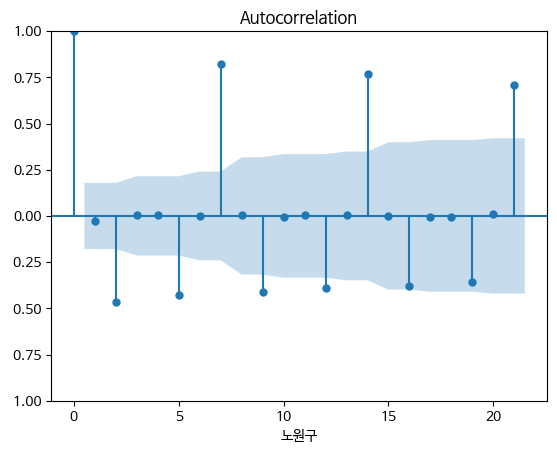

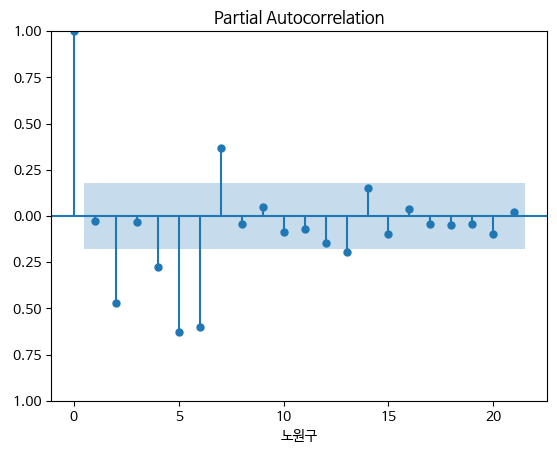

In [ ]:
acf_pacf(sub_노원)

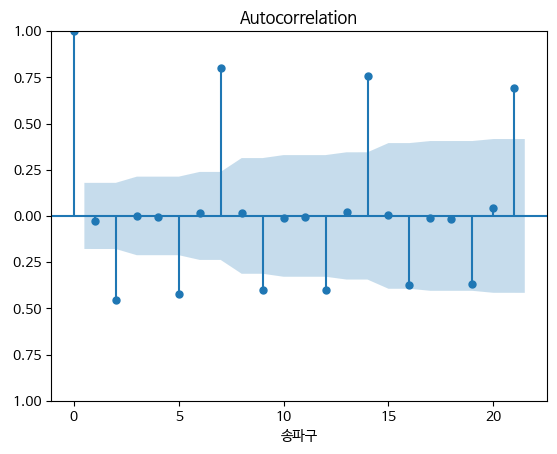

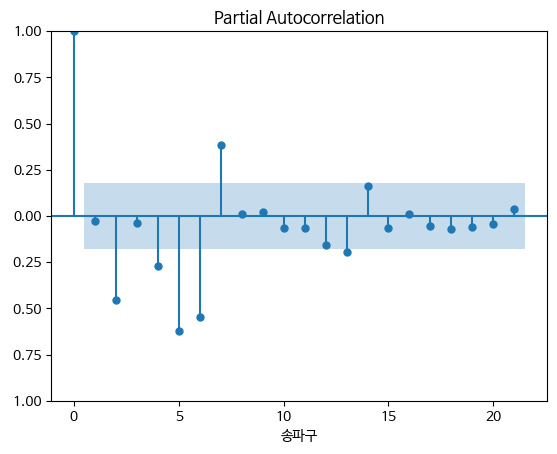

In [ ]:
acf_pacf(sub_송파)

## SARIMA

In [ ]:
def SARIMA(df):

    df.index = pd.DatetimeIndex(df.index.values, freq='D')

    i=0
    p = d = q = P = D = Q = list(range(0, 2))
    S = [7]
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = list(itertools.product(P, D, Q, S))
    best_pdq = None
    best_seasonal_pdq = None
    best_aic = float('inf')
    best_model = None
    best_result = None

    for param in pdq:
        for seasonal_param in seasonal_pdq:
            try:
                model = sm.tsa.statespace.SARIMAX(df['count'], order=param, seasonal_order=seasonal_param)
                result = model.fit()
                aic = result.aic
                i += 1
                if (aic < best_aic) & (aic > 1000):
                    best_aic = aic
                    best_pdq = param
                    best_seasonal_pdq = seasonal_param
                    best_model = model
                    best_result = result
                if i % 30 == 0:
                    print(i)
            except:
                continue

    print('Best SARIMA{}x{} model >> AIC: {}'.format(best_pdq, best_seasonal_pdq, best_aic))
    print(best_result.summary())

    best_result.plot_diagnostics(figsize=(15,12))
    plt.show()

    #잔차에 담기
    df['resid'] = best_result.resid

30
60
Best SARIMA(1, 1, 0)x(0, 1, 1, 7) model >> AIC: 2433.59963469003
                                      SARIMAX Results                                      
Dep. Variable:                               count   No. Observations:                  121
Model:             SARIMAX(1, 1, 0)x(0, 1, [1], 7)   Log Likelihood               -1213.800
Date:                             Tue, 07 Nov 2023   AIC                           2433.600
Time:                                     06:35:46   BIC                           2441.782
Sample:                                 12-01-2022   HQIC                          2436.920
                                      - 03-31-2023                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1961      0.054   

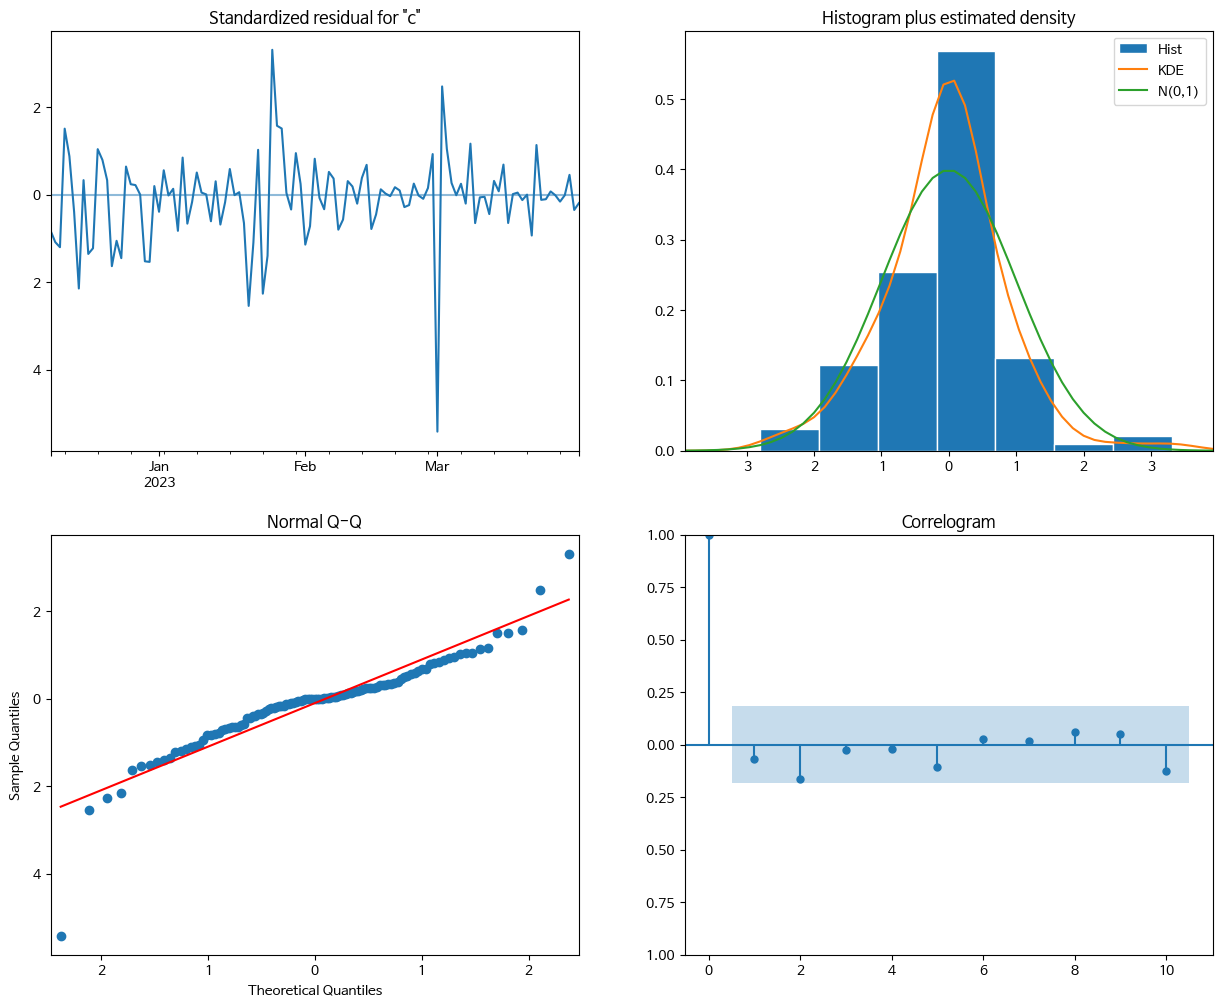

In [ ]:
SARIMA(sub_강남)

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


30


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


60
Best SARIMA(1, 1, 1)x(1, 1, 1, 7) model >> AIC: 2334.3065842934816
                                     SARIMAX Results                                     
Dep. Variable:                             count   No. Observations:                  121
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood               -1162.153
Date:                           Tue, 07 Nov 2023   AIC                           2334.307
Time:                                   06:36:43   BIC                           2347.944
Sample:                               12-01-2022   HQIC                          2339.840
                                    - 03-31-2023                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5238      0.235      2.232      0.0

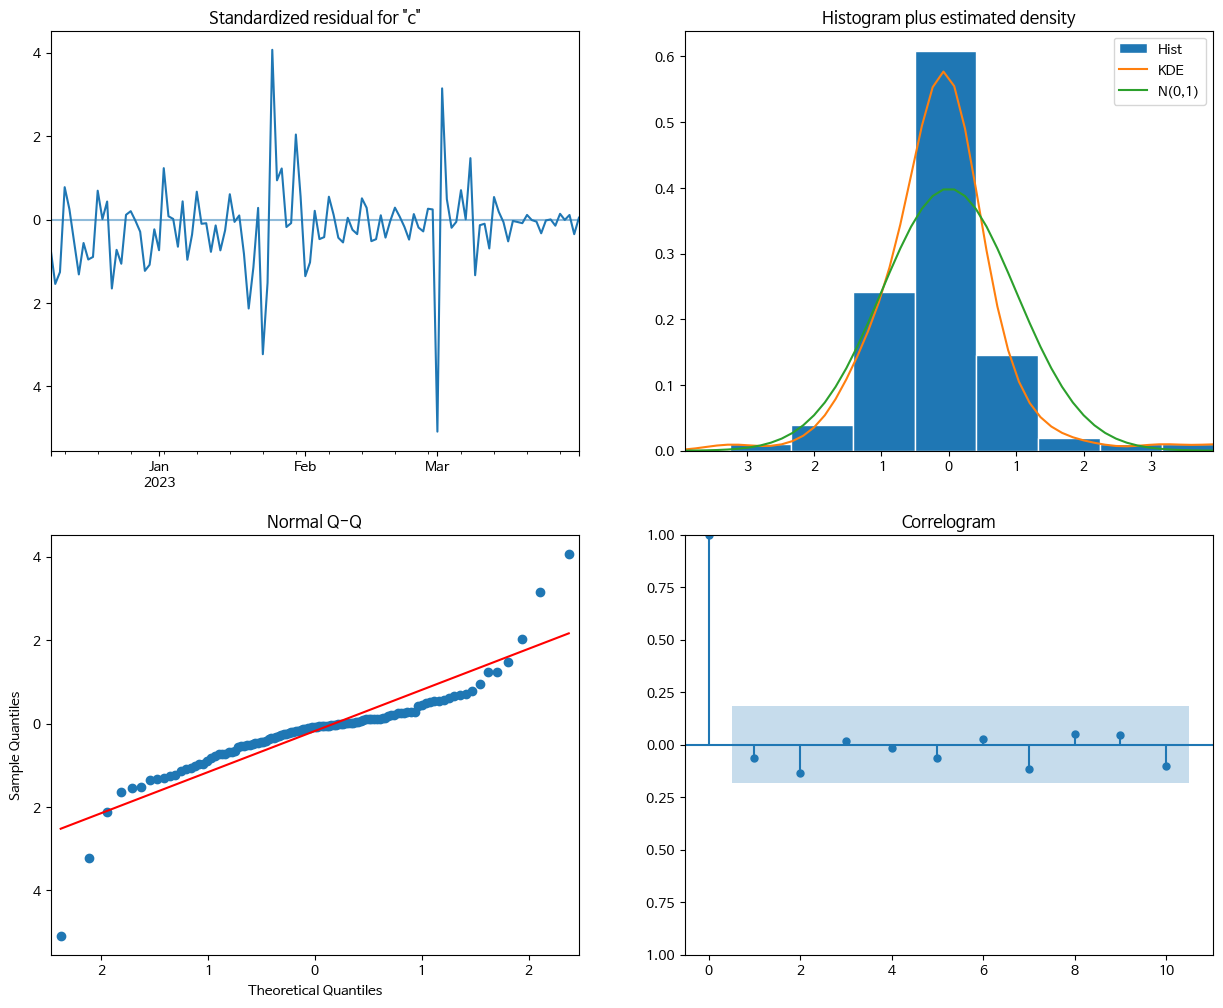

In [ ]:
SARIMA(sub_강서)

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


30


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


60
Best SARIMA(0, 1, 1)x(1, 1, 1, 7) model >> AIC: 2412.5063813155275
                                     SARIMAX Results                                     
Dep. Variable:                             count   No. Observations:                  121
Model:             SARIMAX(0, 1, 1)x(1, 1, 1, 7)   Log Likelihood               -1202.253
Date:                           Tue, 07 Nov 2023   AIC                           2412.506
Time:                                   06:37:14   BIC                           2423.416
Sample:                               12-01-2022   HQIC                          2416.933
                                    - 03-31-2023                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1491      0.060     -2.486      0.0

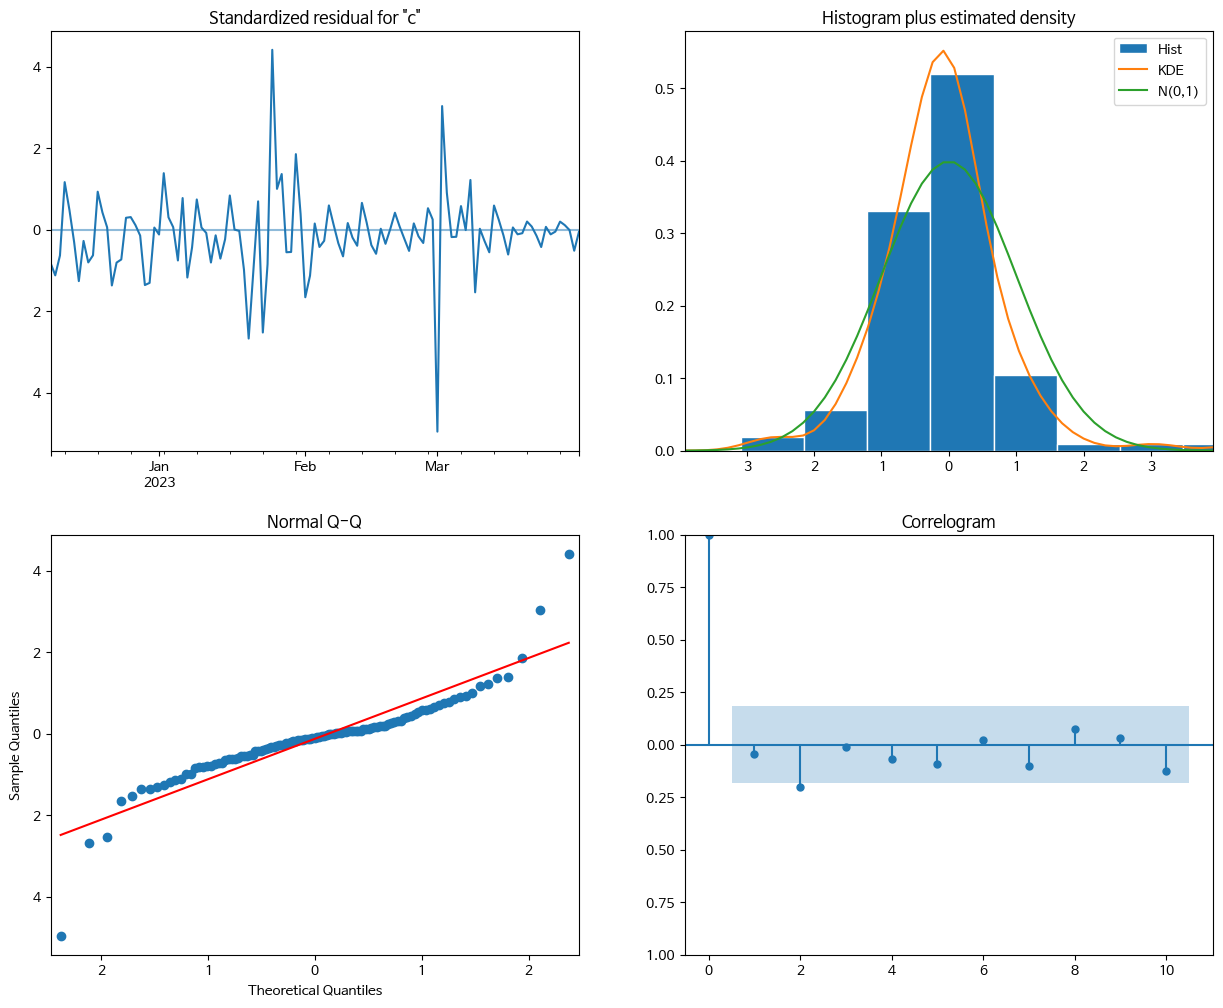

In [ ]:
SARIMA(sub_관악)

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


30


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


60


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Best SARIMA(0, 1, 1)x(0, 1, 1, 7) model >> AIC: 2426.4908567835046
                                     SARIMAX Results                                     
Dep. Variable:                             count   No. Observations:                  121
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 7)   Log Likelihood               -1210.245
Date:                           Tue, 07 Nov 2023   AIC                           2426.491
Time:                                   06:37:47   BIC                           2434.673
Sample:                               12-01-2022   HQIC                          2429.811
                                    - 03-31-2023                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2115      0.049     -4.353      0.000 

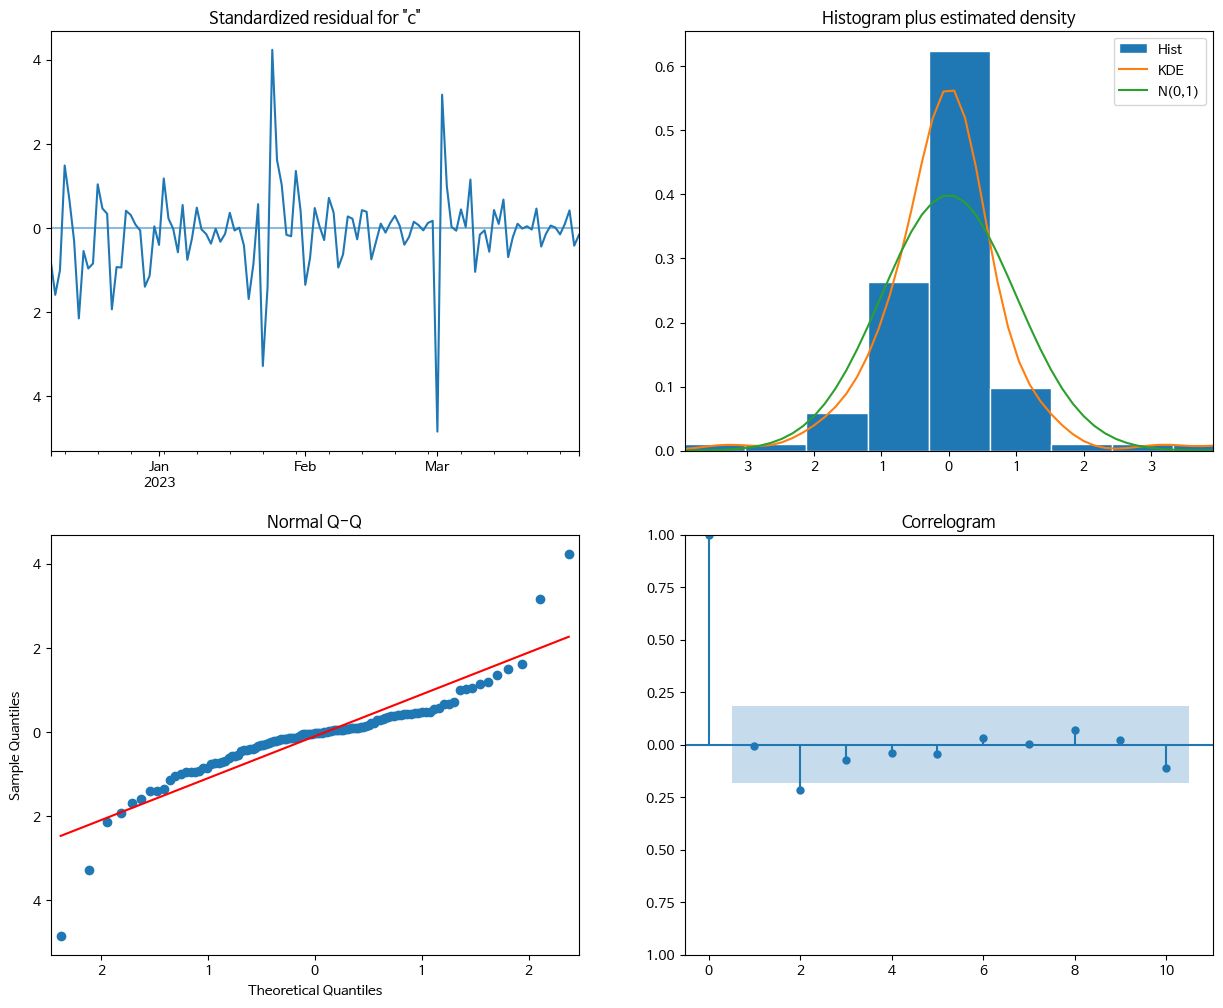

In [ ]:
SARIMA(sub_노원)

30
60
Best SARIMA(0, 1, 0)x(1, 1, 1, 7) model >> AIC: 2511.0279759378345
                                      SARIMAX Results                                      
Dep. Variable:                               count   No. Observations:                  121
Model:             SARIMAX(0, 1, 0)x(1, 1, [1], 7)   Log Likelihood               -1252.514
Date:                             Tue, 07 Nov 2023   AIC                           2511.028
Time:                                     06:38:15   BIC                           2519.210
Sample:                                 12-01-2022   HQIC                          2514.348
                                      - 03-31-2023                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L7        0.1922      0.107 

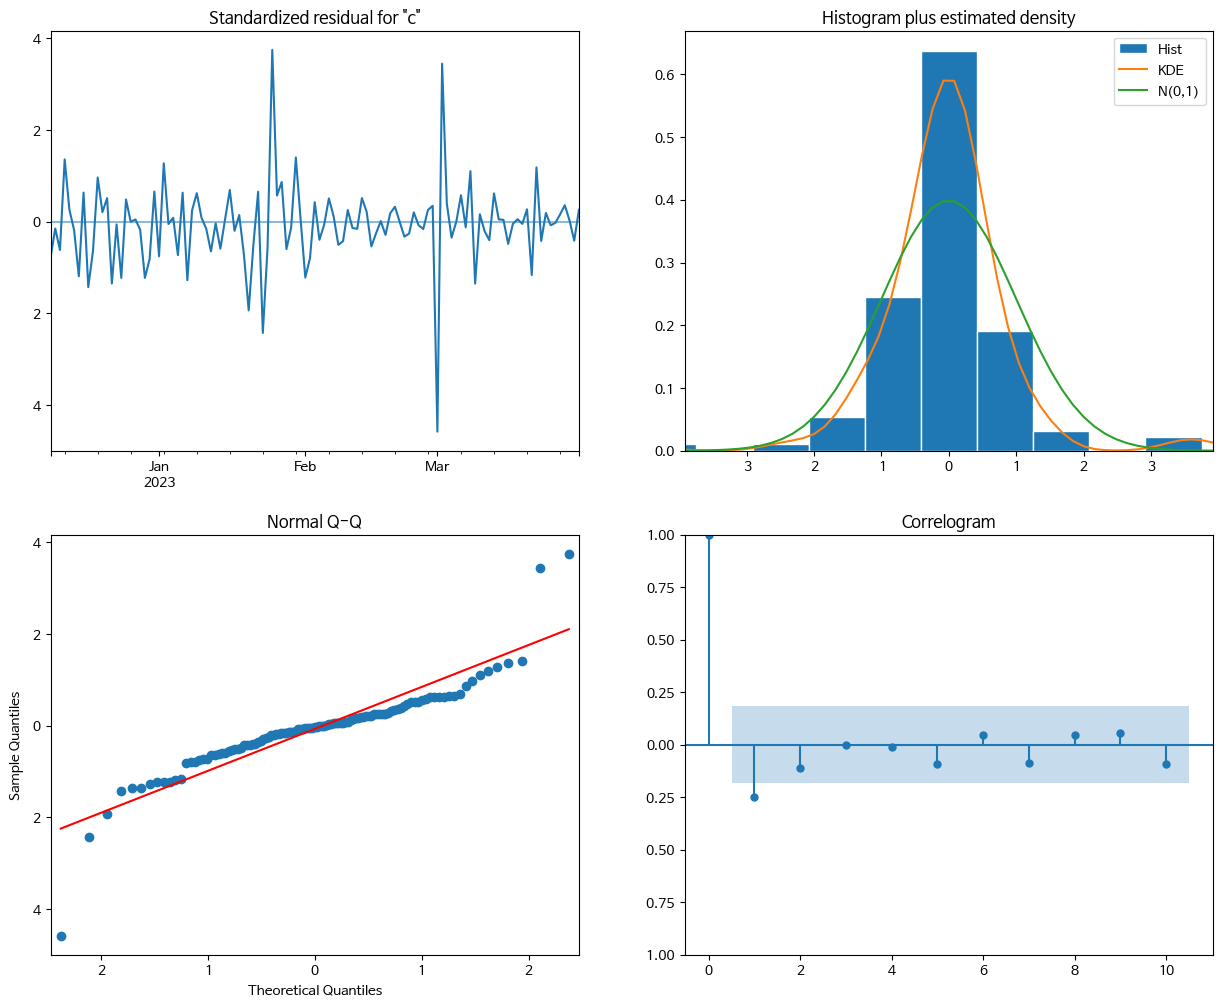

In [ ]:
SARIMA(sub_송파)

##표준화잔차

In [ ]:
def standardized_residuals(df):
    df['stdresid'] = (df['resid'] - np.mean(df['resid'])) / np.std(df['resid'])
    return df.head()

In [ ]:
standardized_residuals(sub_강남)
standardized_residuals(sub_강서)
standardized_residuals(sub_관악)
standardized_residuals(sub_노원)
standardized_residuals(sub_송파)

,area,count,resid,stdresid
2022-12-01,송파구,119114,119114.0,5.677475
2022-12-02,송파구,127248,8134.0,0.418191
2022-12-03,송파구,73833,-53415.0,-2.498584
2022-12-04,송파구,51341,-22492.0,-1.033159
2022-12-05,송파구,113226,61885.0,2.965422


In [ ]:
sub_강남.to_csv('/content/drive/MyDrive/BADA/바다톤/data/sub_강남_귀가시간대_표준화잔차.csv')
sub_강서.to_csv('/content/drive/MyDrive/BADA/바다톤/data/sub_강서_귀가시간대_표준화잔차.csv')
sub_관악.to_csv('/content/drive/MyDrive/BADA/바다톤/data/sub_관악_귀가시간대_표준화잔차.csv')
sub_노원.to_csv('/content/drive/MyDrive/BADA/바다톤/data/sub_노원_귀가시간대_표준화잔차.csv')
sub_송파.to_csv('/content/drive/MyDrive/BADA/바다톤/data/sub_송파_귀가시간대_표준화잔차.csv')

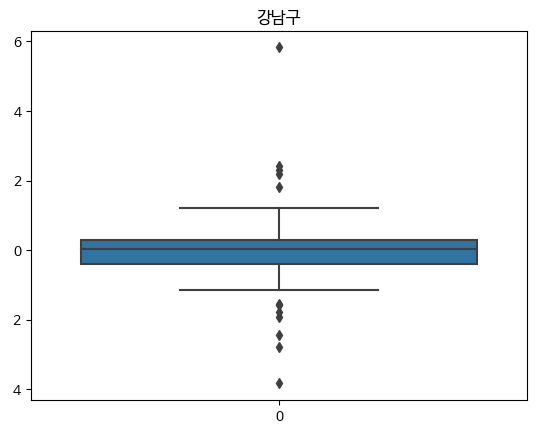

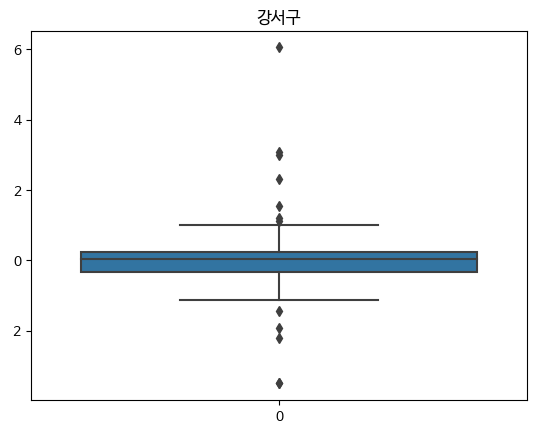

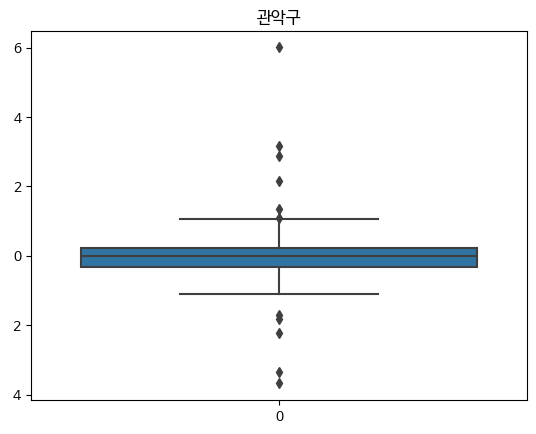

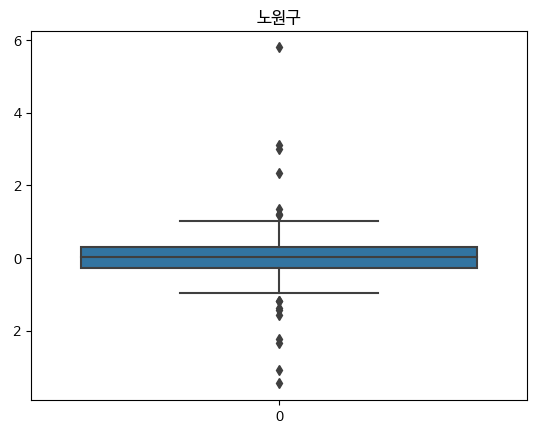

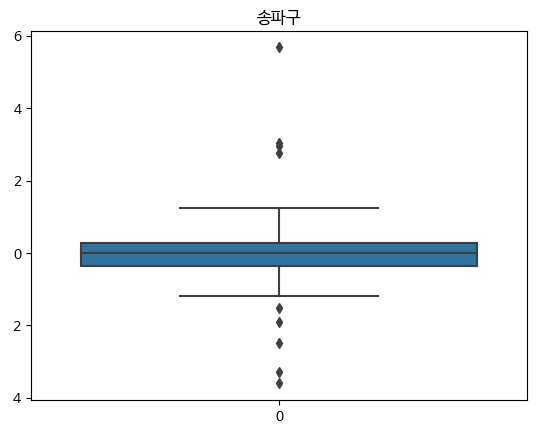

In [ ]:
for df in [sub_강남, sub_강서, sub_관악, sub_노원, sub_송파]:
    plt.title(df['area'][0])
    sns.boxplot(df['stdresid'])
    plt.show()

## 이상치 탐지

In [ ]:
def find_outliers(df):
    outlier_df = pd.DataFrame()
    q3 = df['stdresid'].quantile(0.75)
    q1 = df['stdresid'].quantile(0.25)
    iqr = q3 - q1
    outlier_range = (df['stdresid'] < q1 - 1.5*iqr) | (df['stdresid'] > q3 + 1.5*iqr)
    outlier_df = df['stdresid'].loc[outlier_range]
    print(outlier_df)

In [ ]:
find_outliers(sub_강남)

2022-12-01    5.824243
2022-12-02    2.199101
2022-12-03   -2.446571
2022-12-04   -1.925315
2022-12-05    2.302115
2022-12-08   -2.773275
2022-12-15   -1.555994
2023-01-20   -1.779130
2023-01-23   -1.579163
2023-01-25    2.408231
2023-03-01   -3.830287
2023-03-02    1.807364
Name: stdresid, dtype: float64


In [ ]:
find_outliers(sub_강서)

2022-12-01    6.048124
2022-12-02    1.193316
2022-12-03   -1.911429
2022-12-05    3.076965
2022-12-08   -3.479148
2023-01-20   -1.432736
2023-01-23   -2.216107
2023-01-25    2.999418
2023-01-30    1.542741
2023-03-01   -3.496892
2023-03-02    2.308759
2023-03-08    1.129185
Name: stdresid, dtype: float64


In [ ]:
find_outliers(sub_관악)

2022-12-01    6.004890
2022-12-02    1.091676
2022-12-03   -2.227267
2022-12-05    2.865048
2022-12-08   -3.679297
2023-01-20   -1.819970
2023-01-23   -1.715798
2023-01-25    3.167744
2023-01-30    1.358982
2023-03-01   -3.362121
2023-03-02    2.151301
Name: stdresid, dtype: float64


In [ ]:
find_outliers(sub_노원)

2022-12-01    5.797218
2022-12-02    1.352566
2022-12-03   -2.228484
2022-12-04   -1.437628
2022-12-05    2.991994
2022-12-08   -3.071198
2022-12-10   -1.187443
2022-12-12    1.191904
2022-12-15   -1.558976
2022-12-22   -1.374121
2023-01-20   -1.177709
2023-01-23   -2.327982
2023-01-25    3.101050
2023-01-26    1.212870
2023-03-01   -3.453598
2023-03-02    2.329307
Name: stdresid, dtype: float64


In [ ]:
find_outliers(sub_송파)

2022-12-01    5.677475
2022-12-03   -2.498584
2022-12-05    2.965422
2022-12-08   -3.297256
2023-01-20   -1.517476
2023-01-23   -1.911664
2023-01-25    3.038229
2023-03-01   -3.603582
2023-03-02    2.769995
Name: stdresid, dtype: float64


2월이 없다!

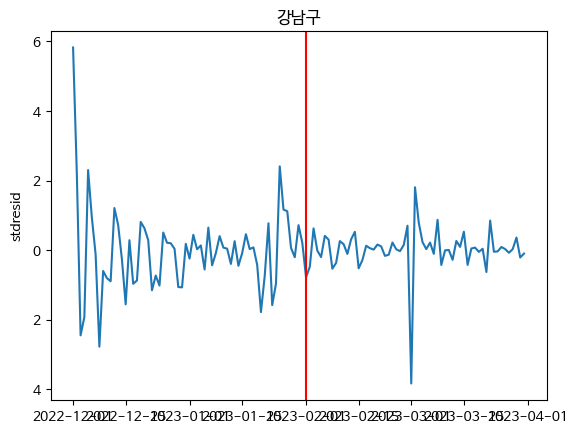

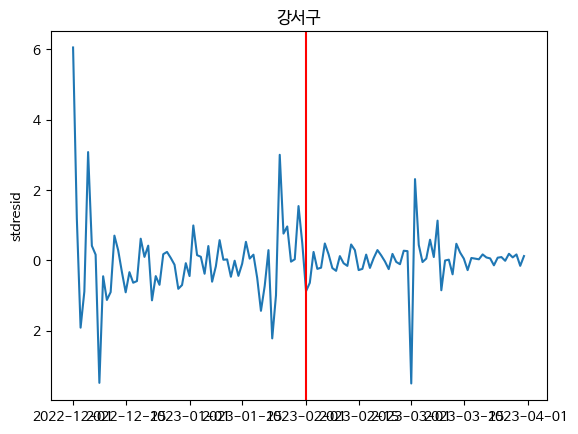

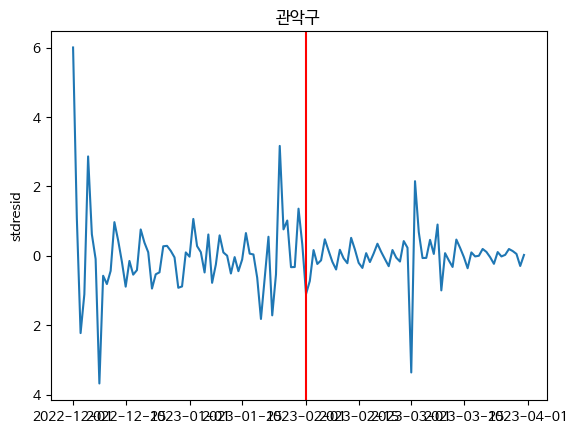

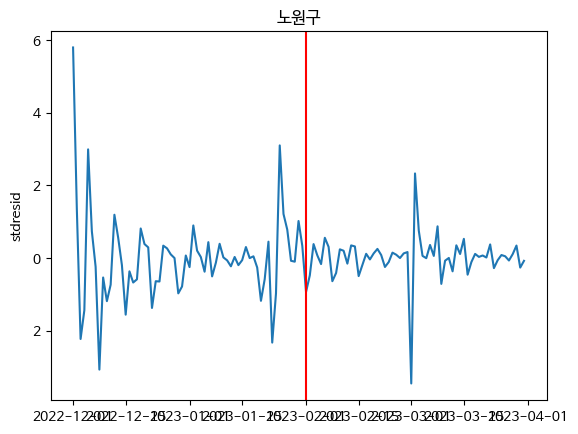

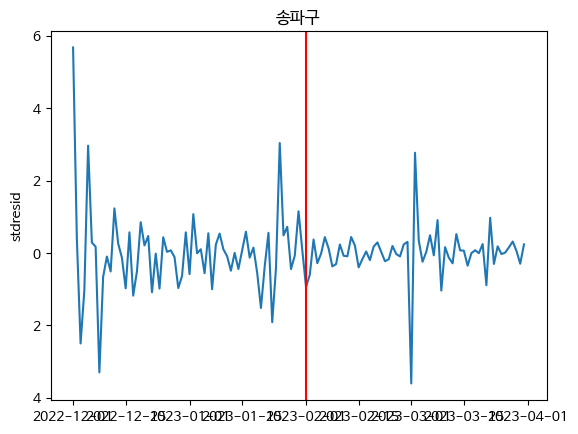

In [ ]:
for df in [sub_강남, sub_강서, sub_관악, sub_노원, sub_송파]:
    plt.title(df['area'][0])
    sns.lineplot(df['stdresid'])
    plt.axvline(x=datetime(2023,2,1), color='red', linestyle='solid')
    plt.show()

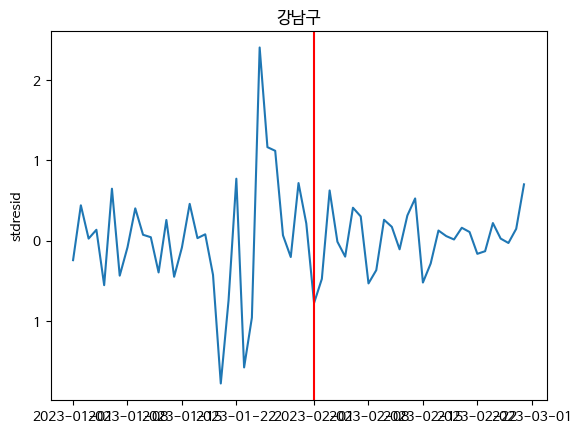

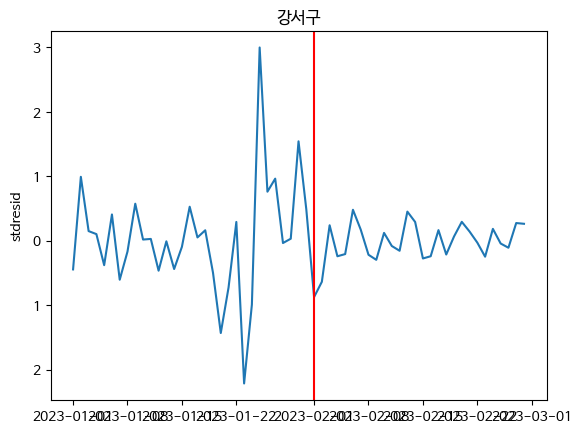

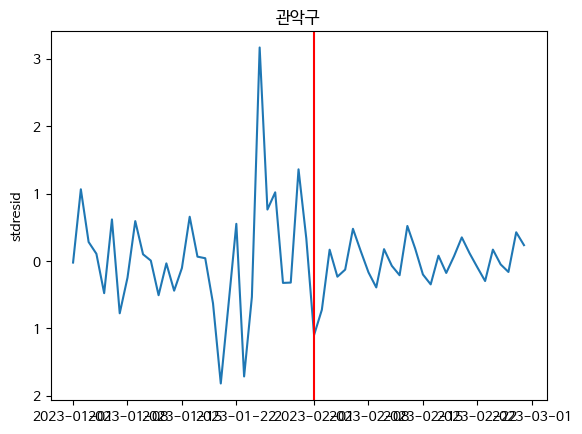

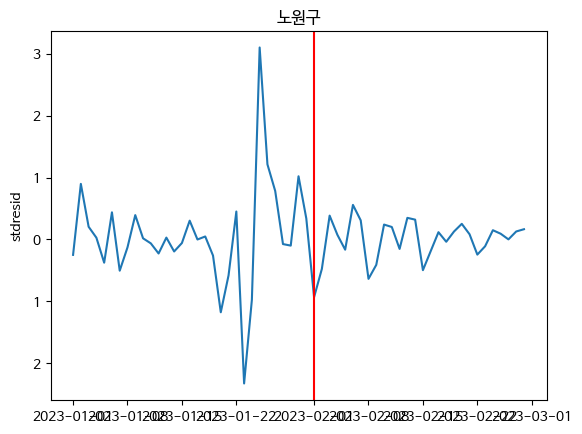

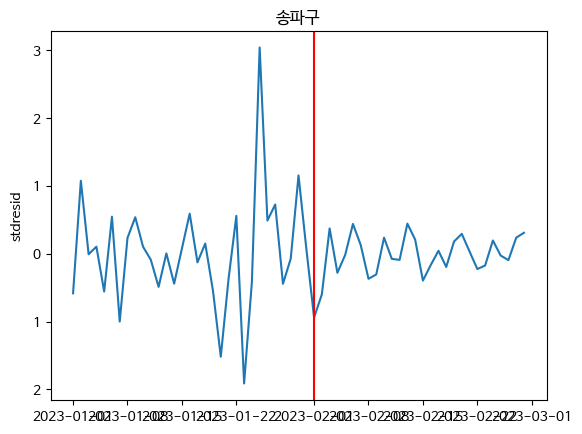

In [ ]:
for df in [sub_강남, sub_강서, sub_관악, sub_노원, sub_송파]:
    new_df = df[(df.index>='2023-01-01') & (df.index<='2023-02-28')]
    plt.title(df['area'][0])
    sns.lineplot(new_df['stdresid'])
    plt.axvline(x=datetime(2023,2,1), color='red', linestyle='solid')
    plt.show()

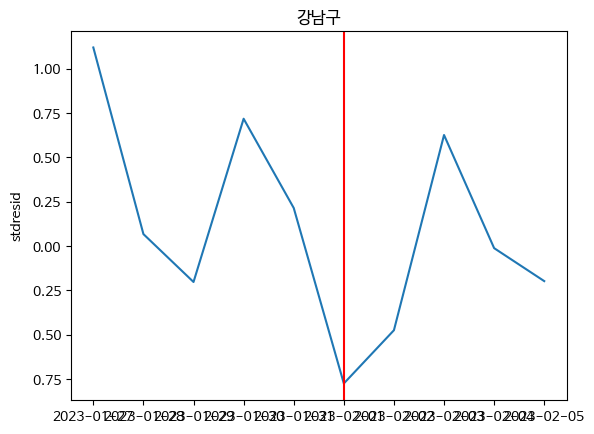

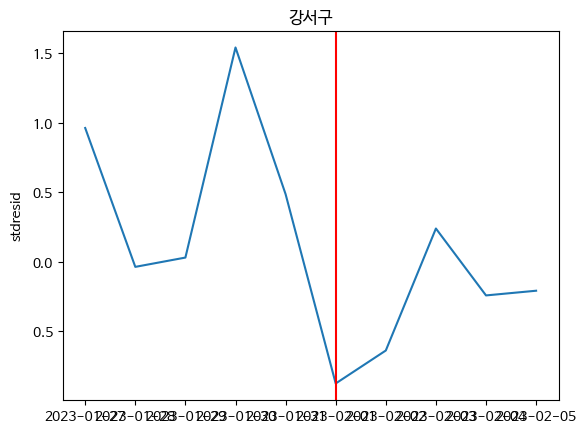

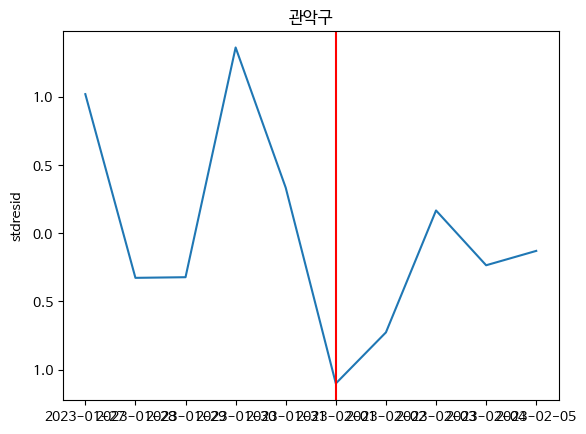

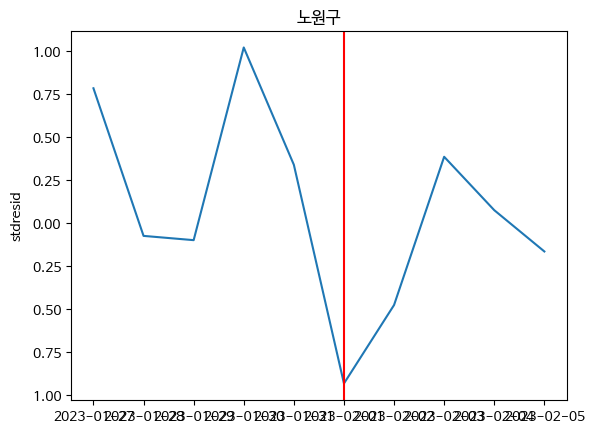

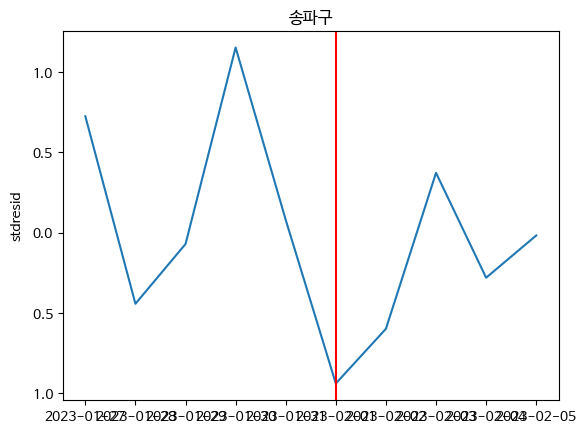

In [ ]:
for df in [sub_강남, sub_강서, sub_관악, sub_노원, sub_송파]:
    new_df = df[(df.index>='2023-01-27') & (df.index<='2023-02-05')]
    plt.title(df['area'][0])
    sns.lineplot(new_df['stdresid'])
    plt.axvline(x=datetime(2023,2,1), color='red', linestyle='solid')
    plt.show()

# 시계열 분석 (귀가시간대, 전후 15일)

In [ ]:
sub5 = sub.copy(); sub5

,area,count
date,,
2022-12-01,강남구,89537
2022-12-02,강남구,105567
2022-12-03,강남구,63954
2022-12-04,강남구,41568
2022-12-05,강남구,81236
...,...,...
2023-03-27,송파구,123592
2023-03-28,송파구,128811
2023-03-29,송파구,132763


In [ ]:
sub5 = sub5.reset_index(); sub5

,date,area,count
0,2022-12-01,강남구,89537
1,2022-12-02,강남구,105567
2,2022-12-03,강남구,63954
3,2022-12-04,강남구,41568
4,2022-12-05,강남구,81236
...,...,...,...
600,2023-03-27,송파구,123592
601,2023-03-28,송파구,128811
602,2023-03-29,송파구,132763
603,2023-03-30,송파구,134163


In [ ]:
sub5.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 605 entries, 0 to 604
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    605 non-null    datetime64[ns]
 1   area    605 non-null    object        
 2   count   605 non-null    int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 14.3+ KB


In [ ]:
#기간축소
sub5 = sub5[(sub5['date']>=pd.datetime(2023,1,17)) & (sub5['date']<=pd.datetime(2023,2,15))]; sub5

,date,area,count
47,2023-01-17,강남구,90955
48,2023-01-18,강남구,95462
49,2023-01-19,강남구,95116
50,2023-01-20,강남구,77067
51,2023-01-21,강남구,29312
...,...,...,...
556,2023-02-11,송파구,73989
557,2023-02-12,송파구,53804
558,2023-02-13,송파구,118391
559,2023-02-14,송파구,126526


In [ ]:
sub5 = pd.DataFrame(sub5.groupby(['area','date']).sum()['count']); sub5

count
area date              
강남구  2023-01-17   90955
     2023-01-18   95462
     2023-01-19   95116
     2023-01-20   77067
     2023-01-21   29312
...                 ...
송파구  2023-02-11   73989
     2023-02-12   53804
     2023-02-13  118391
     2023-02-14  126526
     2023-02-15  125260

[150 rows x 1 columns]

In [ ]:
sub5 = sub5.reset_index(level=0); sub5

,area,count
date,,
2023-01-17,강남구,90955
2023-01-18,강남구,95462
2023-01-19,강남구,95116
2023-01-20,강남구,77067
2023-01-21,강남구,29312
...,...,...
2023-02-11,송파구,73989
2023-02-12,송파구,53804
2023-02-13,송파구,118391


In [ ]:
sub5_강남 = sub5[sub5['area']=='강남구']
sub5_강서 = sub5[sub5['area']=='강서구']
sub5_관악 = sub5[sub5['area']=='관악구']
sub5_노원 = sub5[sub5['area']=='노원구']
sub5_송파 = sub5[sub5['area']=='송파구']

## stationarity 검정

In [ ]:
def adfuller_test(df):
        result = adfuller(df)

        labels = ['ADF Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used']

        for label, value in zip(labels, result):
            print(label + ' : ' + str(value) )

        if result[1] <= 0.05:
            print('정상성', '\n')
        else:
            print('비정상성', '\n')

In [ ]:
adfuller_test(sub5_강남['count'])
adfuller_test(sub5_강서['count'])
adfuller_test(sub5_관악['count'])
adfuller_test(sub5_노원['count'])
adfuller_test(sub5_송파['count'])

ADF Test Statistic : -5.555093279035209
p-value : 1.5875501850386434e-06
#Lags Used : 9
Number of Observations Used : 20
정상성 

ADF Test Statistic : -3.8563951131412155
p-value : 0.002380250872486376
#Lags Used : 9
Number of Observations Used : 20
정상성 

ADF Test Statistic : -4.382215685568563
p-value : 0.00031909922536939745
#Lags Used : 9
Number of Observations Used : 20
정상성 

ADF Test Statistic : -3.6453549582656013
p-value : 0.004950846079892909
#Lags Used : 9
Number of Observations Used : 20
정상성 

ADF Test Statistic : -4.1838198141195155
p-value : 0.0007017088826148733
#Lags Used : 9
Number of Observations Used : 20
정상성 



다 정상성

## seasonal_decompose

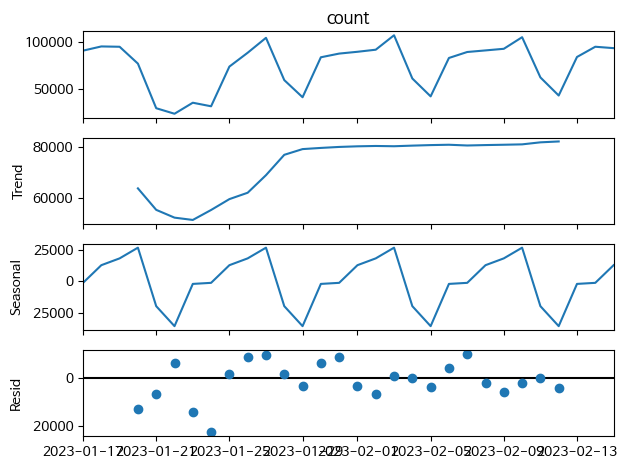

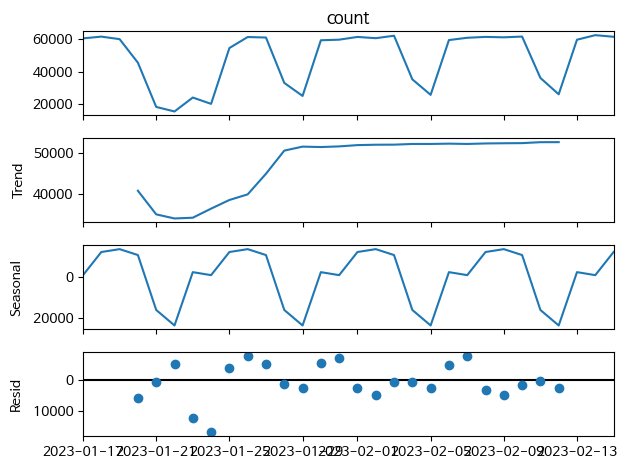

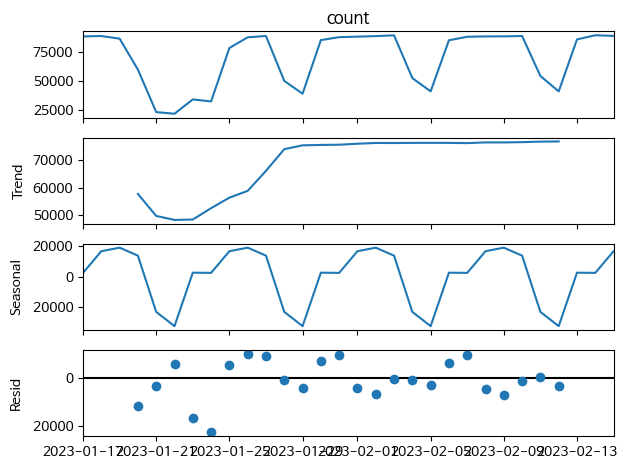

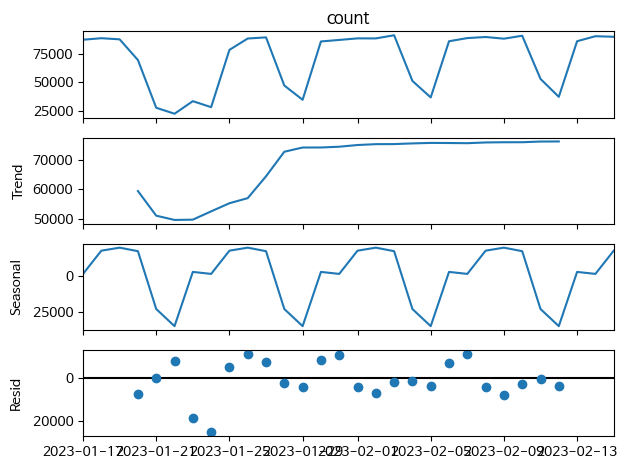

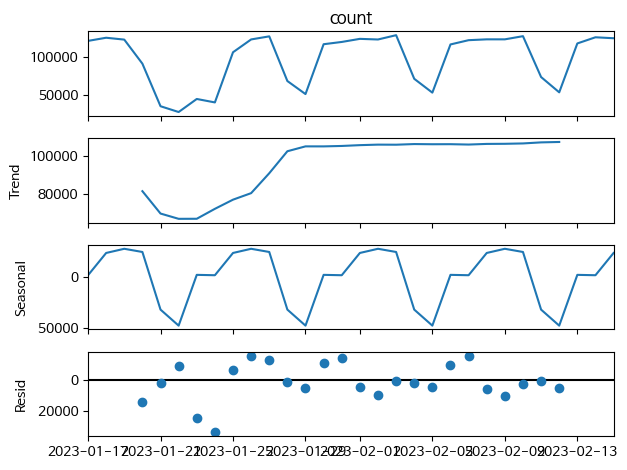

In [ ]:
for df in [sub5_강남, sub5_강서, sub5_관악, sub5_노원, sub5_송파]:
    series = df['count']
    result = seasonal_decompose(series, model='additive')
    result.plot()

## ARIMA

In [ ]:
def ARIMA(df):

    df.index = pd.DatetimeIndex(df.index.values, freq='D')

    p = list(range(0,5))
    d = [0]
    q = list(range(0,5))
    pdq = list(itertools.product(p, d, q))

    best_aic = np.inf
    best_pdq = None
    tmp_model = None
    best_model = None

    for param in pdq:
        tmp_model = sm.tsa.arima.ARIMA(df['count'], order=param, freq='D')
        result = tmp_model.fit()

        if result.aic < best_aic:
            best_aic = result.aic
            best_pdq = param
            best_model = tmp_model

    print('Best ARIMA {} model >> AIC: {}'.format(best_pdq, best_aic))

    result_optimal = best_model.fit()

    print(result_optimal.summary())

    result_optimal.plot_diagnostics(figsize=(10,8))
    plt.tight_layout()
    plt.show()
    print()

    #잔차에 담기
    df['resid'] = result_optimal.resid

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op

Best ARIMA (0, 0, 1) model >> AIC: 684.7338396242441
                               SARIMAX Results                                
Dep. Variable:                  count   No. Observations:                   30
Model:                 ARIMA(0, 0, 1)   Log Likelihood                -339.367
Date:                Tue, 07 Nov 2023   AIC                            684.734
Time:                        06:43:37   BIC                            688.937
Sample:                    01-17-2023   HQIC                           686.079
                         - 02-15-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         7.5e+04   8374.748      8.955      0.000    5.86e+04    9.14e+04
ma.L1          0.8832      0.212      4.169      0.000       0.468       1.298

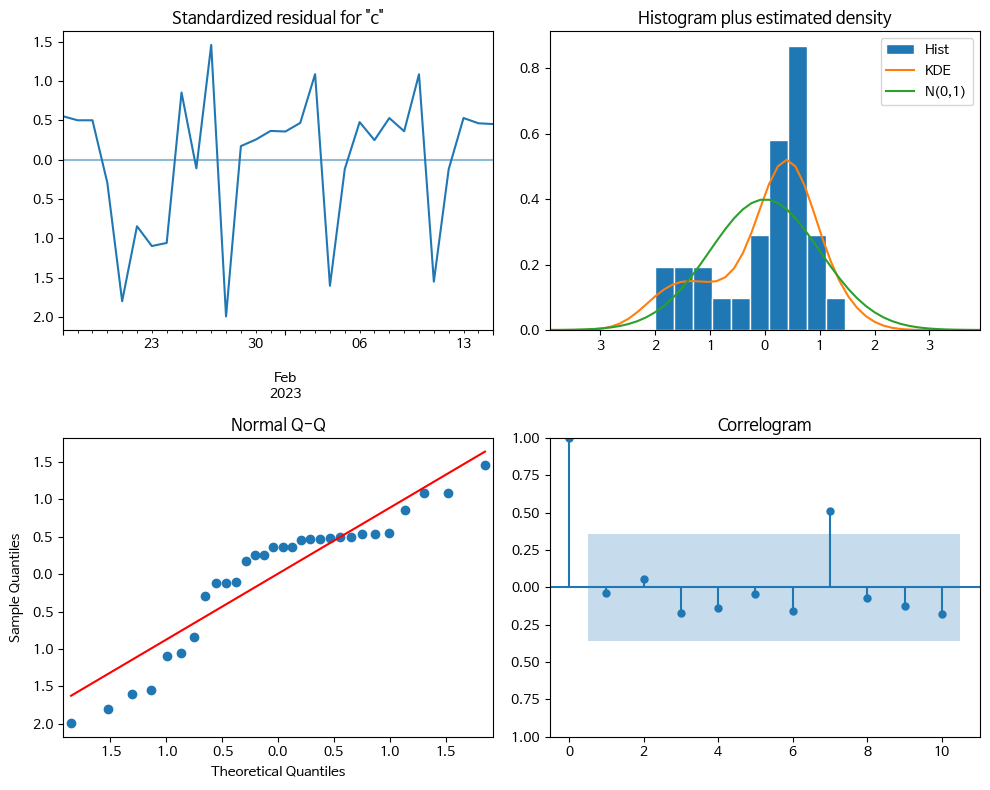

In [ ]:
ARIMA(sub5_강남)

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op

Best ARIMA (0, 0, 1) model >> AIC: 661.5895310548569
                               SARIMAX Results                                
Dep. Variable:                  count   No. Observations:                   30
Model:                 ARIMA(0, 0, 1)   Log Likelihood                -327.795
Date:                Tue, 07 Nov 2023   AIC                            661.590
Time:                        06:43:54   BIC                            665.793
Sample:                    01-17-2023   HQIC                           662.934
                         - 02-15-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.848e+04   5701.545      8.503      0.000    3.73e+04    5.97e+04
ma.L1          0.8170      0.174      4.697      0.000       0.476       1.158

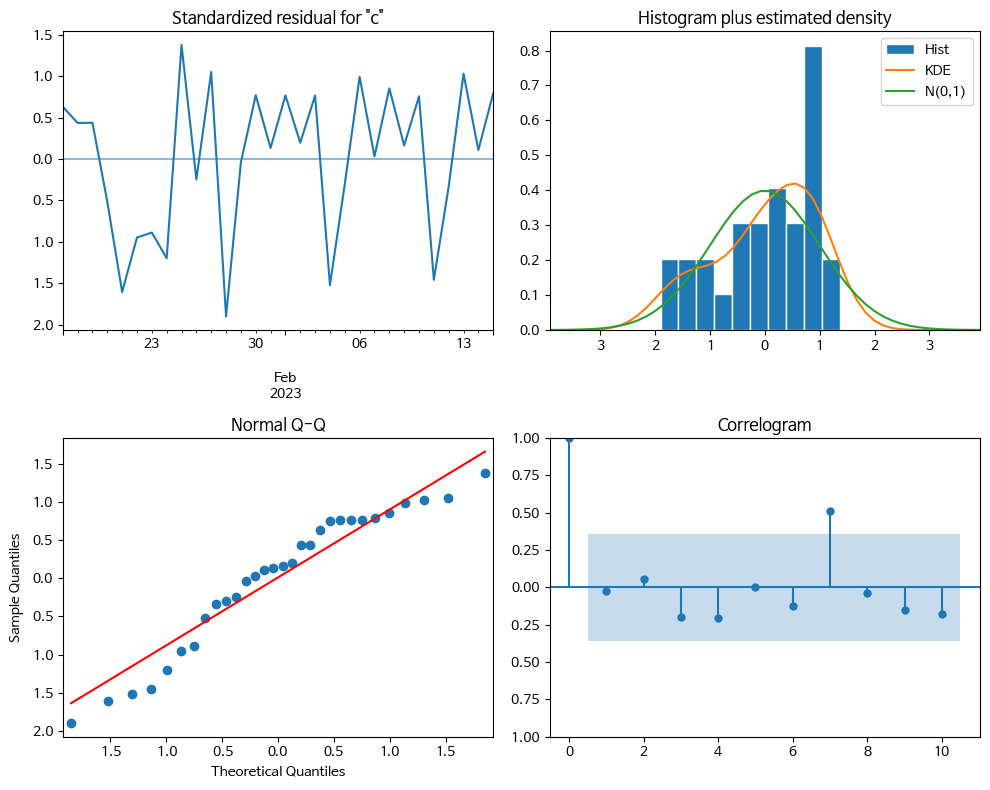

In [ ]:
ARIMA(sub5_강서)

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op

Best ARIMA (0, 0, 1) model >> AIC: 680.9326143898008
                               SARIMAX Results                                
Dep. Variable:                  count   No. Observations:                   30
Model:                 ARIMA(0, 0, 1)   Log Likelihood                -337.466
Date:                Tue, 07 Nov 2023   AIC                            680.933
Time:                        06:44:29   BIC                            685.136
Sample:                    01-17-2023   HQIC                           682.277
                         - 02-15-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       7.052e+04   7552.045      9.338      0.000    5.57e+04    8.53e+04
ma.L1          0.8219      0.167      4.915      0.000       0.494       1.150

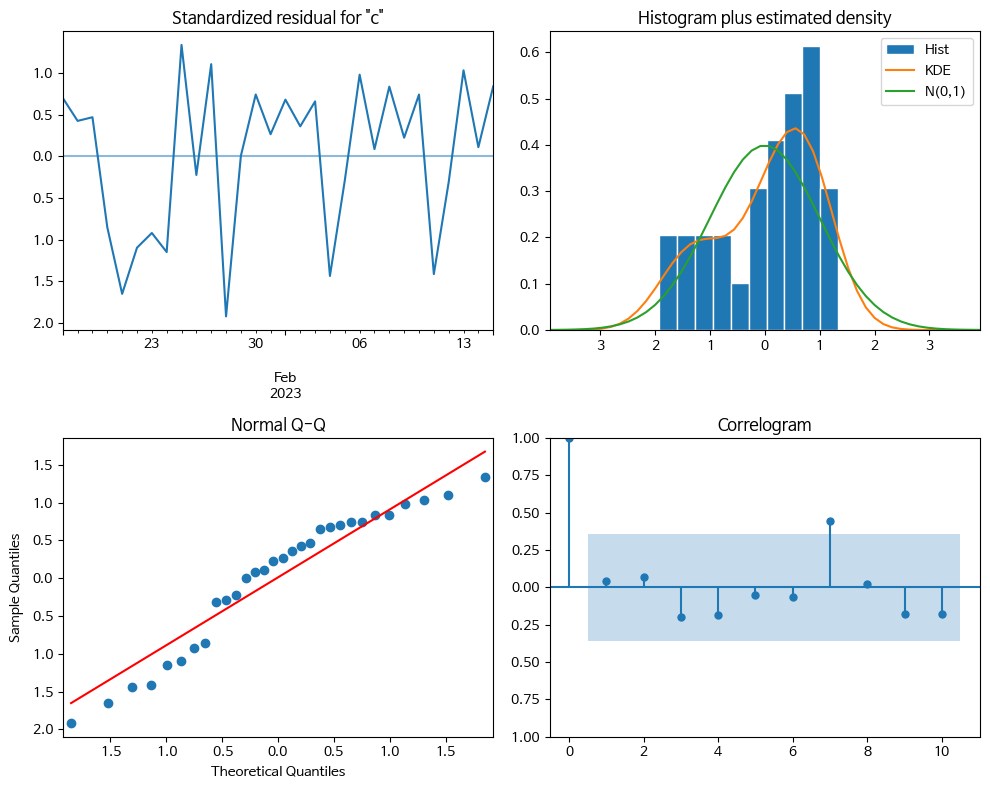

In [ ]:
ARIMA(sub5_관악)

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op

Best ARIMA (0, 0, 1) model >> AIC: 684.704609626653
                               SARIMAX Results                                
Dep. Variable:                  count   No. Observations:                   30
Model:                 ARIMA(0, 0, 1)   Log Likelihood                -339.352
Date:                Tue, 07 Nov 2023   AIC                            684.705
Time:                        06:44:44   BIC                            688.908
Sample:                    01-17-2023   HQIC                           686.049
                         - 02-15-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       7.026e+04   8599.751      8.170      0.000    5.34e+04    8.71e+04
ma.L1          0.8304      0.179      4.643      0.000       0.480       1.181


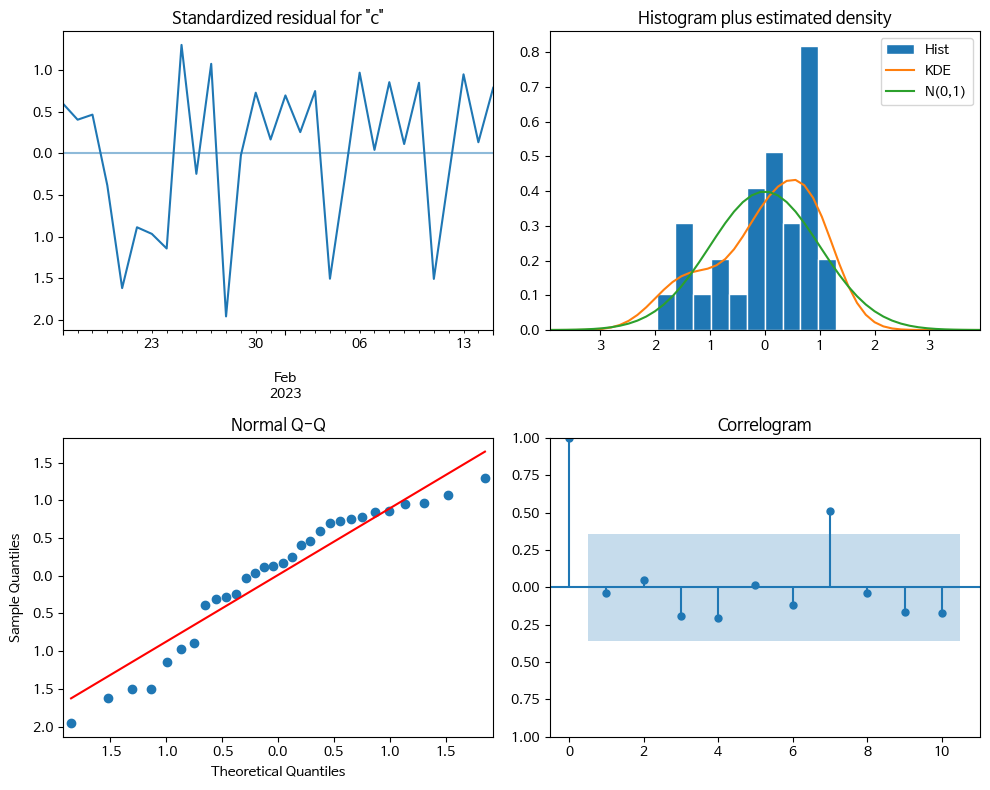

In [ ]:
ARIMA(sub5_노원)

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op

Best ARIMA (0, 0, 1) model >> AIC: 703.5386549421904
                               SARIMAX Results                                
Dep. Variable:                  count   No. Observations:                   30
Model:                 ARIMA(0, 0, 1)   Log Likelihood                -348.769
Date:                Tue, 07 Nov 2023   AIC                            703.539
Time:                        06:44:54   BIC                            707.742
Sample:                    01-17-2023   HQIC                           704.883
                         - 02-15-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       9.811e+04   1.16e+04      8.453      0.000    7.54e+04    1.21e+05
ma.L1          0.8540      0.184      4.631      0.000       0.493       1.215

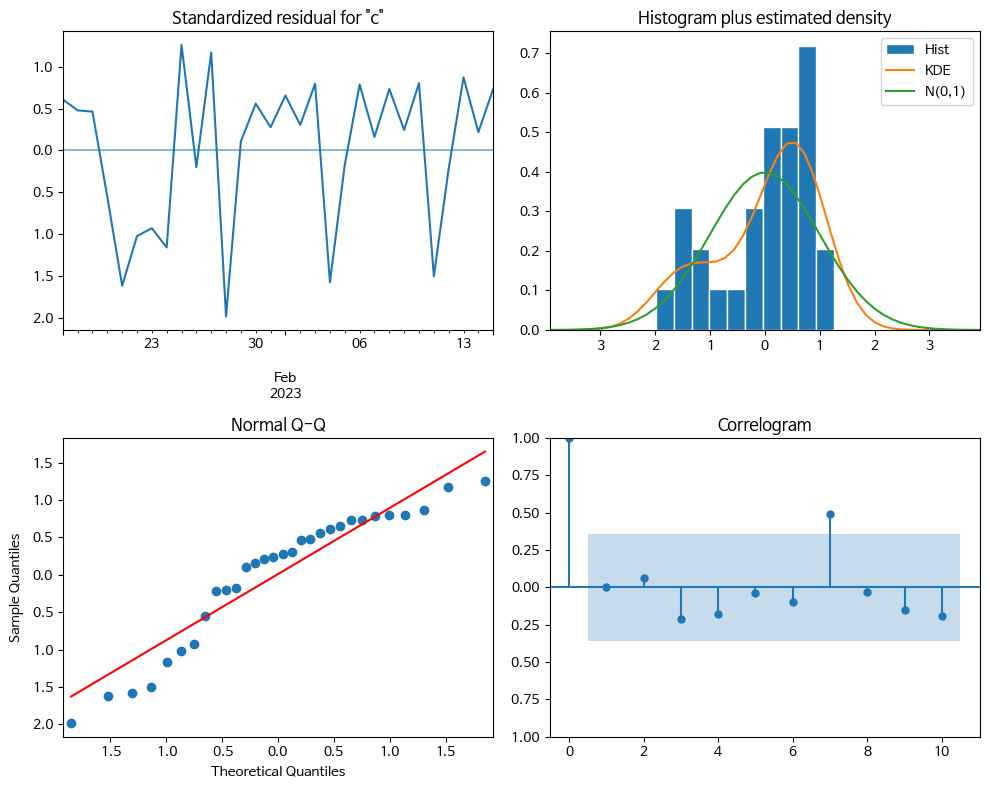

In [ ]:
ARIMA(sub5_송파)

## 표준화잔차

In [ ]:
def standardized_residuals(df):
    df['stdresid'] = (df['resid'] - np.mean(df['resid'])) / np.std(df['resid'])
    return df.head()

In [ ]:
standardized_residuals(sub5_강남)
standardized_residuals(sub5_강서)
standardized_residuals(sub5_관악)
standardized_residuals(sub5_노원)
standardized_residuals(sub5_송파)

,area,count,resid,stdresid
2023-01-17,송파구,121758,23646.633165,0.872804
2023-01-18,송파구,125916,16126.984578,0.589702
2023-01-19,송파구,123453,14808.750669,0.540072
2023-01-20,송파구,91673,-17233.281672,-0.666260
2023-01-21,송파구,35438,-49376.010162,-1.876382


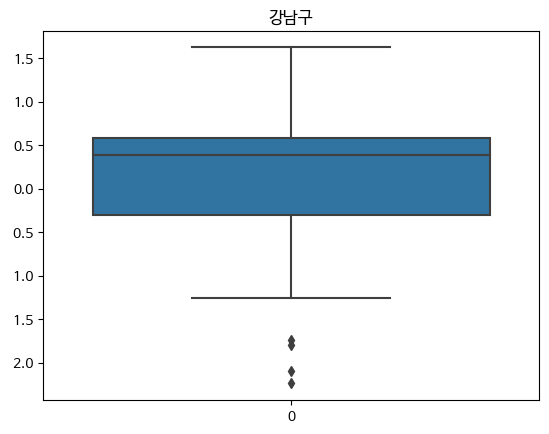

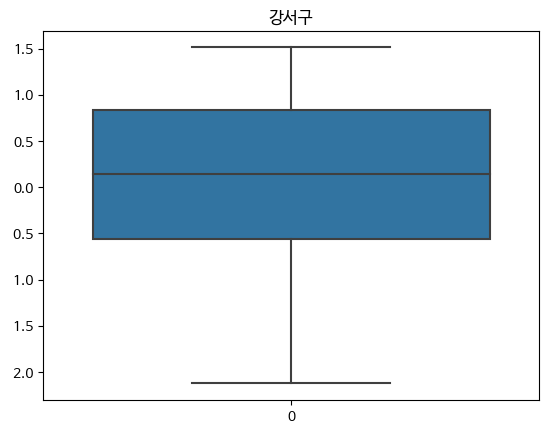

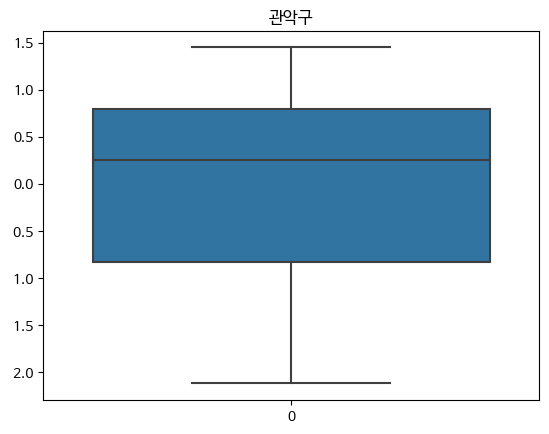

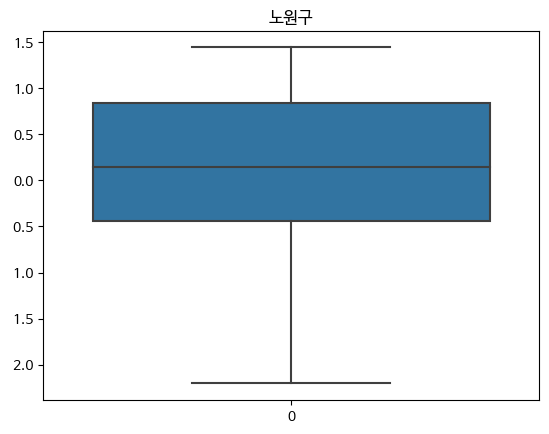

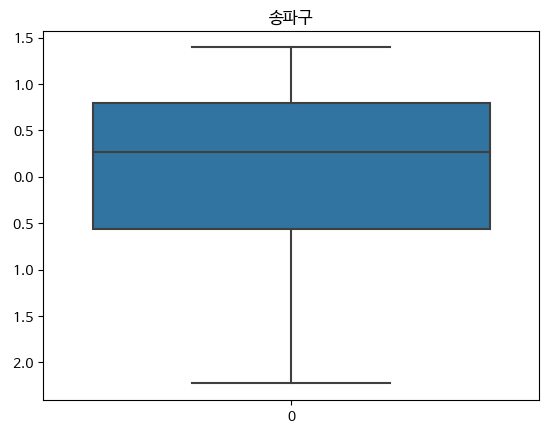

In [ ]:
for df in [sub5_강남, sub5_강서, sub5_관악, sub5_노원, sub5_송파]:
    plt.title(df['area'][0])
    sns.boxplot(df['stdresid'])
    plt.show()

## 이상치 탐지

In [ ]:
def find_outliers(df):
    outlier_df = pd.DataFrame()
    q3 = df['stdresid'].quantile(0.75)
    q1 = df['stdresid'].quantile(0.25)
    iqr = q3 - q1
    outlier_range = (df['stdresid'] < q1 - 1.5*iqr) | (df['stdresid'] > q3 + 1.5*iqr)
    outlier_df = df['stdresid'].loc[outlier_range]
    print(outlier_df)

In [ ]:
find_outliers(sub5_강남)

2023-01-21   -2.098220
2023-01-28   -2.238949
2023-02-04   -1.794662
2023-02-11   -1.734434
Freq: 7D, Name: stdresid, dtype: float64


In [ ]:
find_outliers(sub5_강서)

Series([], Freq: D, Name: stdresid, dtype: float64)


In [ ]:
find_outliers(sub5_관악)

Series([], Freq: D, Name: stdresid, dtype: float64)


In [ ]:
find_outliers(sub5_노원)

Series([], Freq: D, Name: stdresid, dtype: float64)


In [ ]:
find_outliers(sub5_송파)

Series([], Freq: D, Name: stdresid, dtype: float64)


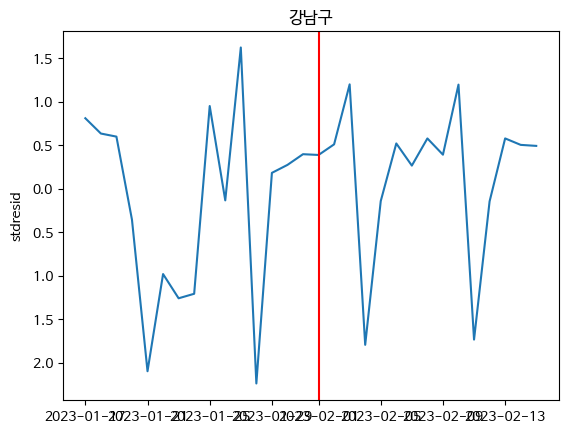

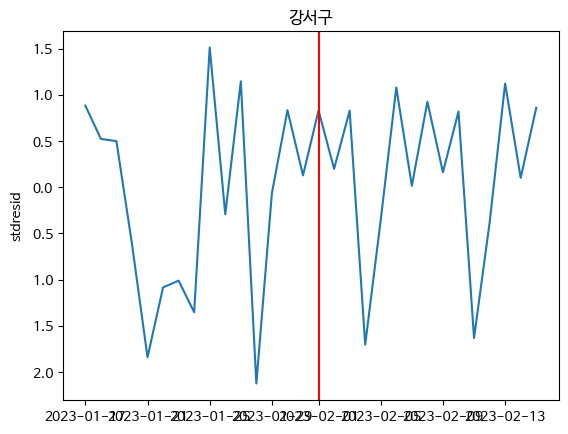

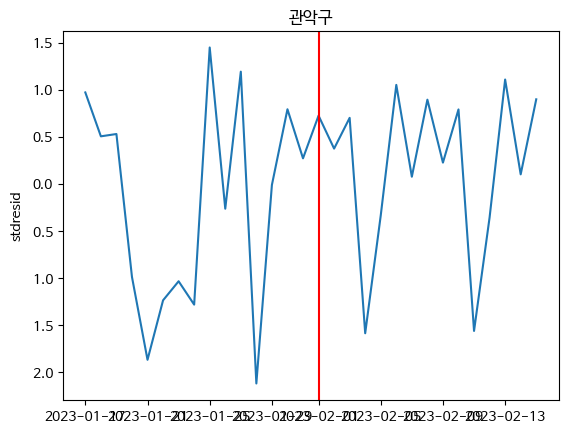

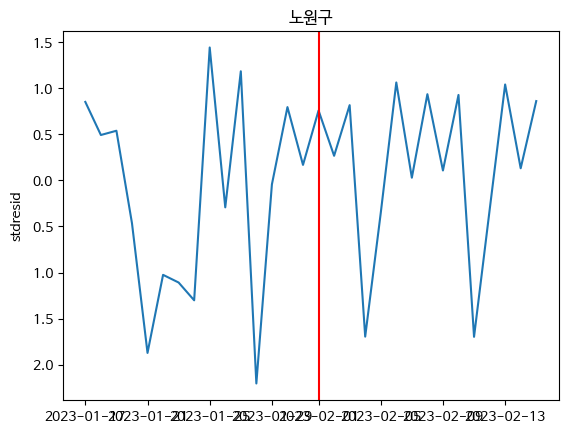

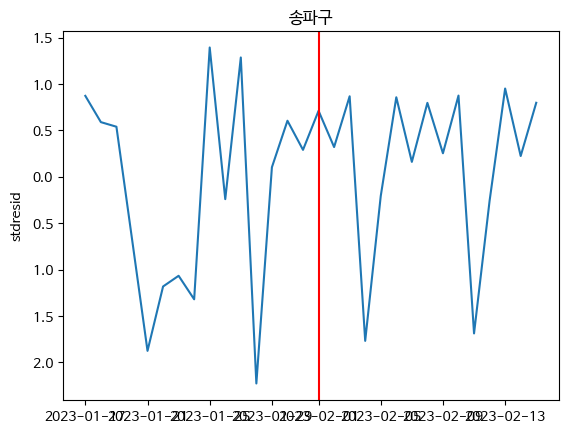

In [ ]:
for df in [sub5_강남, sub5_강서, sub5_관악, sub5_노원, sub5_송파]:
    plt.title(df['area'][0])
    sns.lineplot(df['stdresid'])
    plt.axvline(x=datetime(2023,2,1), color='red', linestyle='solid')
    plt.show()

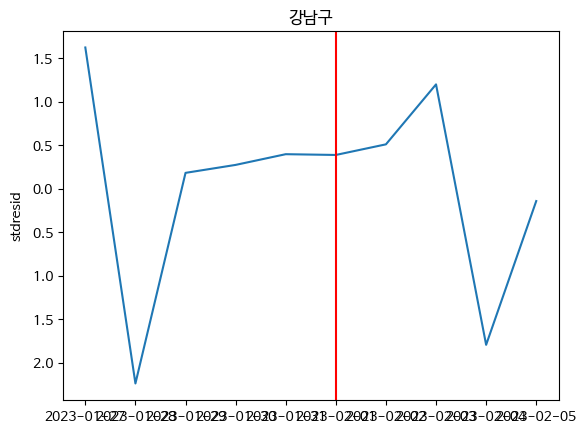

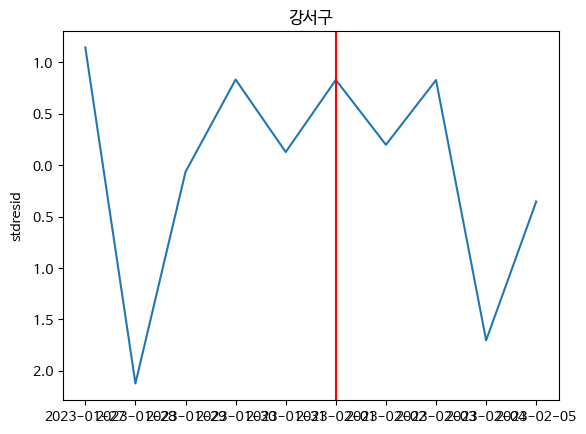

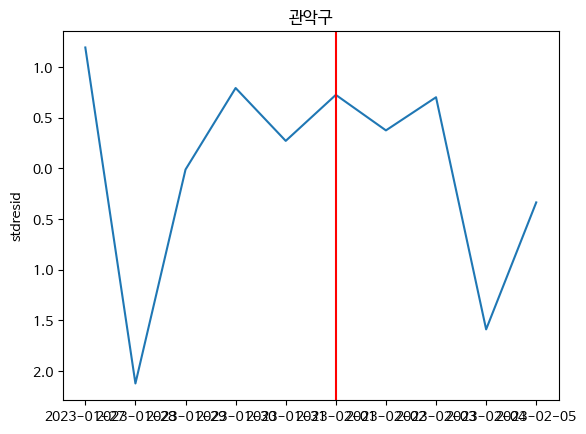

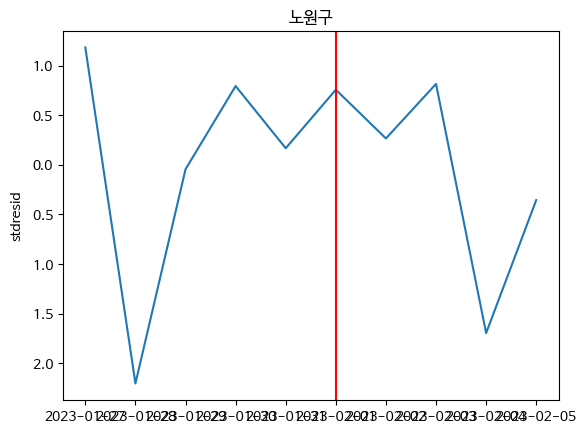

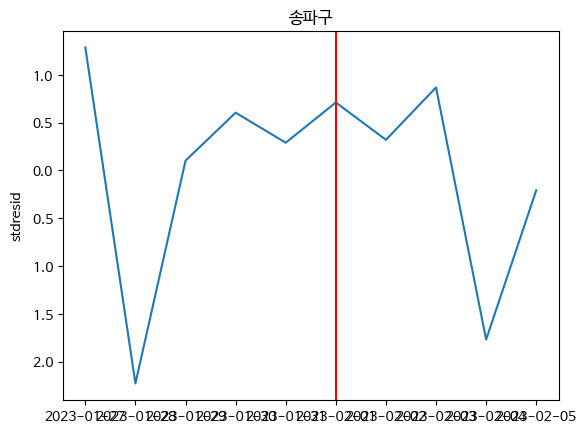

In [ ]:
for df in [sub5_강남, sub5_강서, sub5_관악, sub5_노원, sub5_송파]:
    new_df = df[(df.index>='2023-01-27') & (df.index<='2023-02-05')]
    plt.title(df['area'][0])
    sns.lineplot(new_df['stdresid'])
    plt.axvline(x=datetime(2023,2,1), color='red', linestyle='solid')
    plt.show()

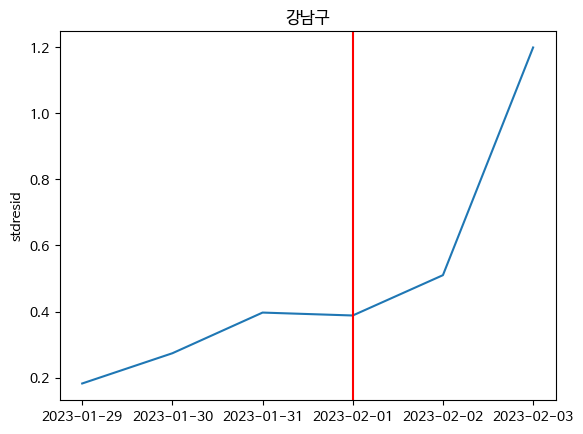

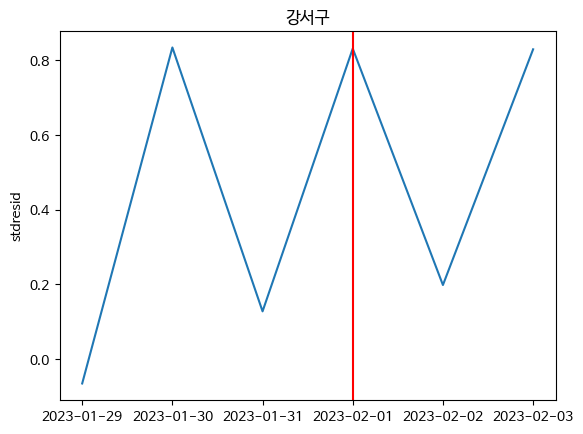

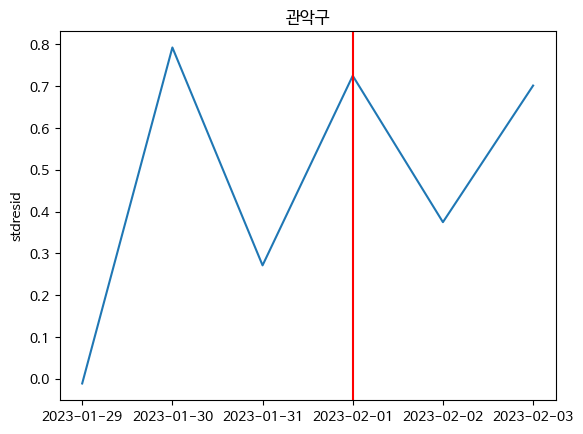

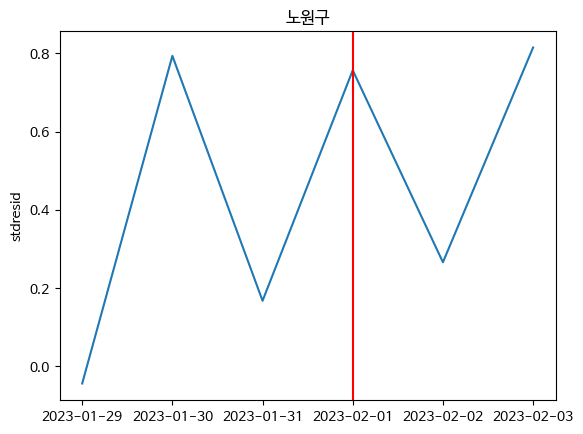

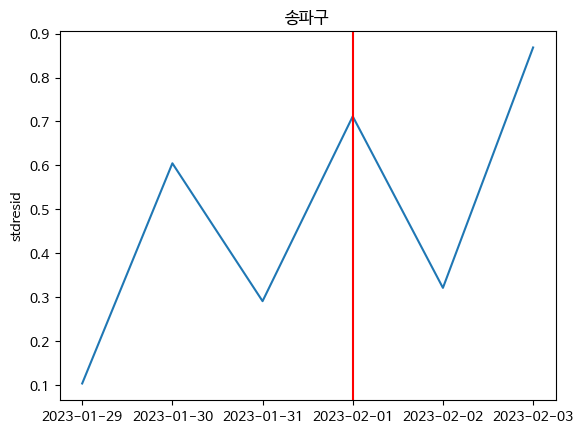

In [ ]:
for df in [sub5_강남, sub5_강서, sub5_관악, sub5_노원, sub5_송파]:
    new_df = df[(df.index>='2023-01-29') & (df.index<='2023-02-03')]
    plt.title(df['area'][0])
    sns.lineplot(new_df['stdresid'])
    plt.axvline(x=datetime(2023,2,1), color='red', linestyle='solid')
    plt.show()